# <div style="text-align: center"> <font size=+5> <ins>ANALYSE DATA</ins> </font> </div>
___

# Loading variables

In [1]:
import pandas as pd
import numpy as np

import warnings

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.dpi' : 300,
                     'mathtext.fontset' : 'stix', 
                     'font.family' : 'STIXGeneral'
                    })

In [2]:
data_issp = pd.read_pickle("Processed_Data/issp_questionnaires.pickle")
data_GDPgrowth = pd.read_pickle("Processed_Data/GDP_growth.pickle")
data_GDPpcap = pd.read_pickle("Processed_Data/GDP_pcap.pickle")

In [13]:
def conv_answers(label):
    convDict = {
        "Strongly Disagree" : -2,
        "Disagree" : -1,
        "Neither Agree nor Disagree" : 0,
        "Agree" : 1,
        "Strongly Agree" : 2,

        "Yes, I have" : 1,
        "No, I have not" : 0,

        'Extremely dangerous': -2,
        'Very dangerous': -1,
        'Somewhat dangerous': 0,
        'Not very dangerous': 1,
        'Not dangerous at all': 2,
    }
    return convDict[label] if label in convDict else label

___
# Interesting variables

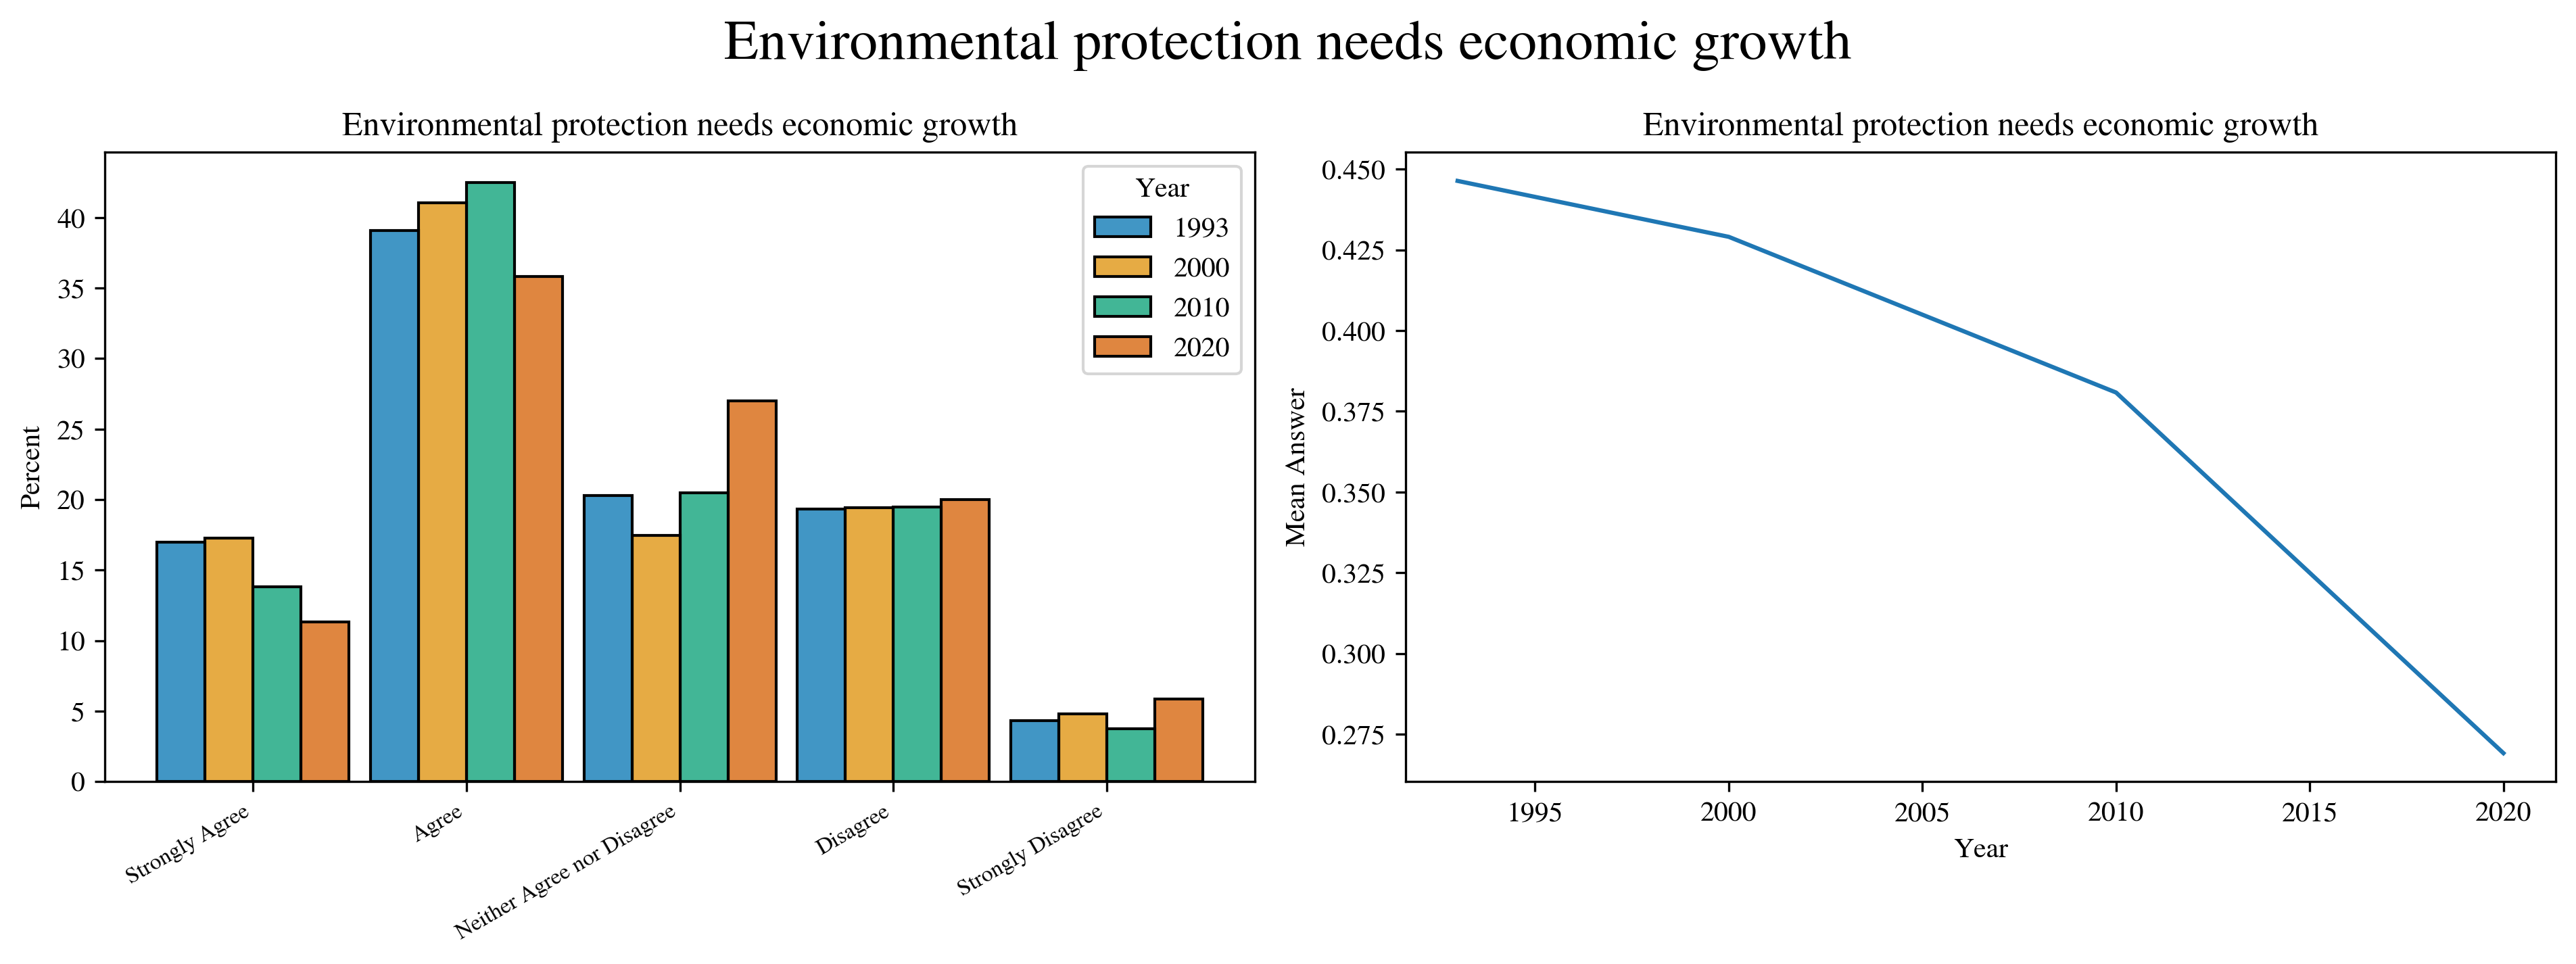

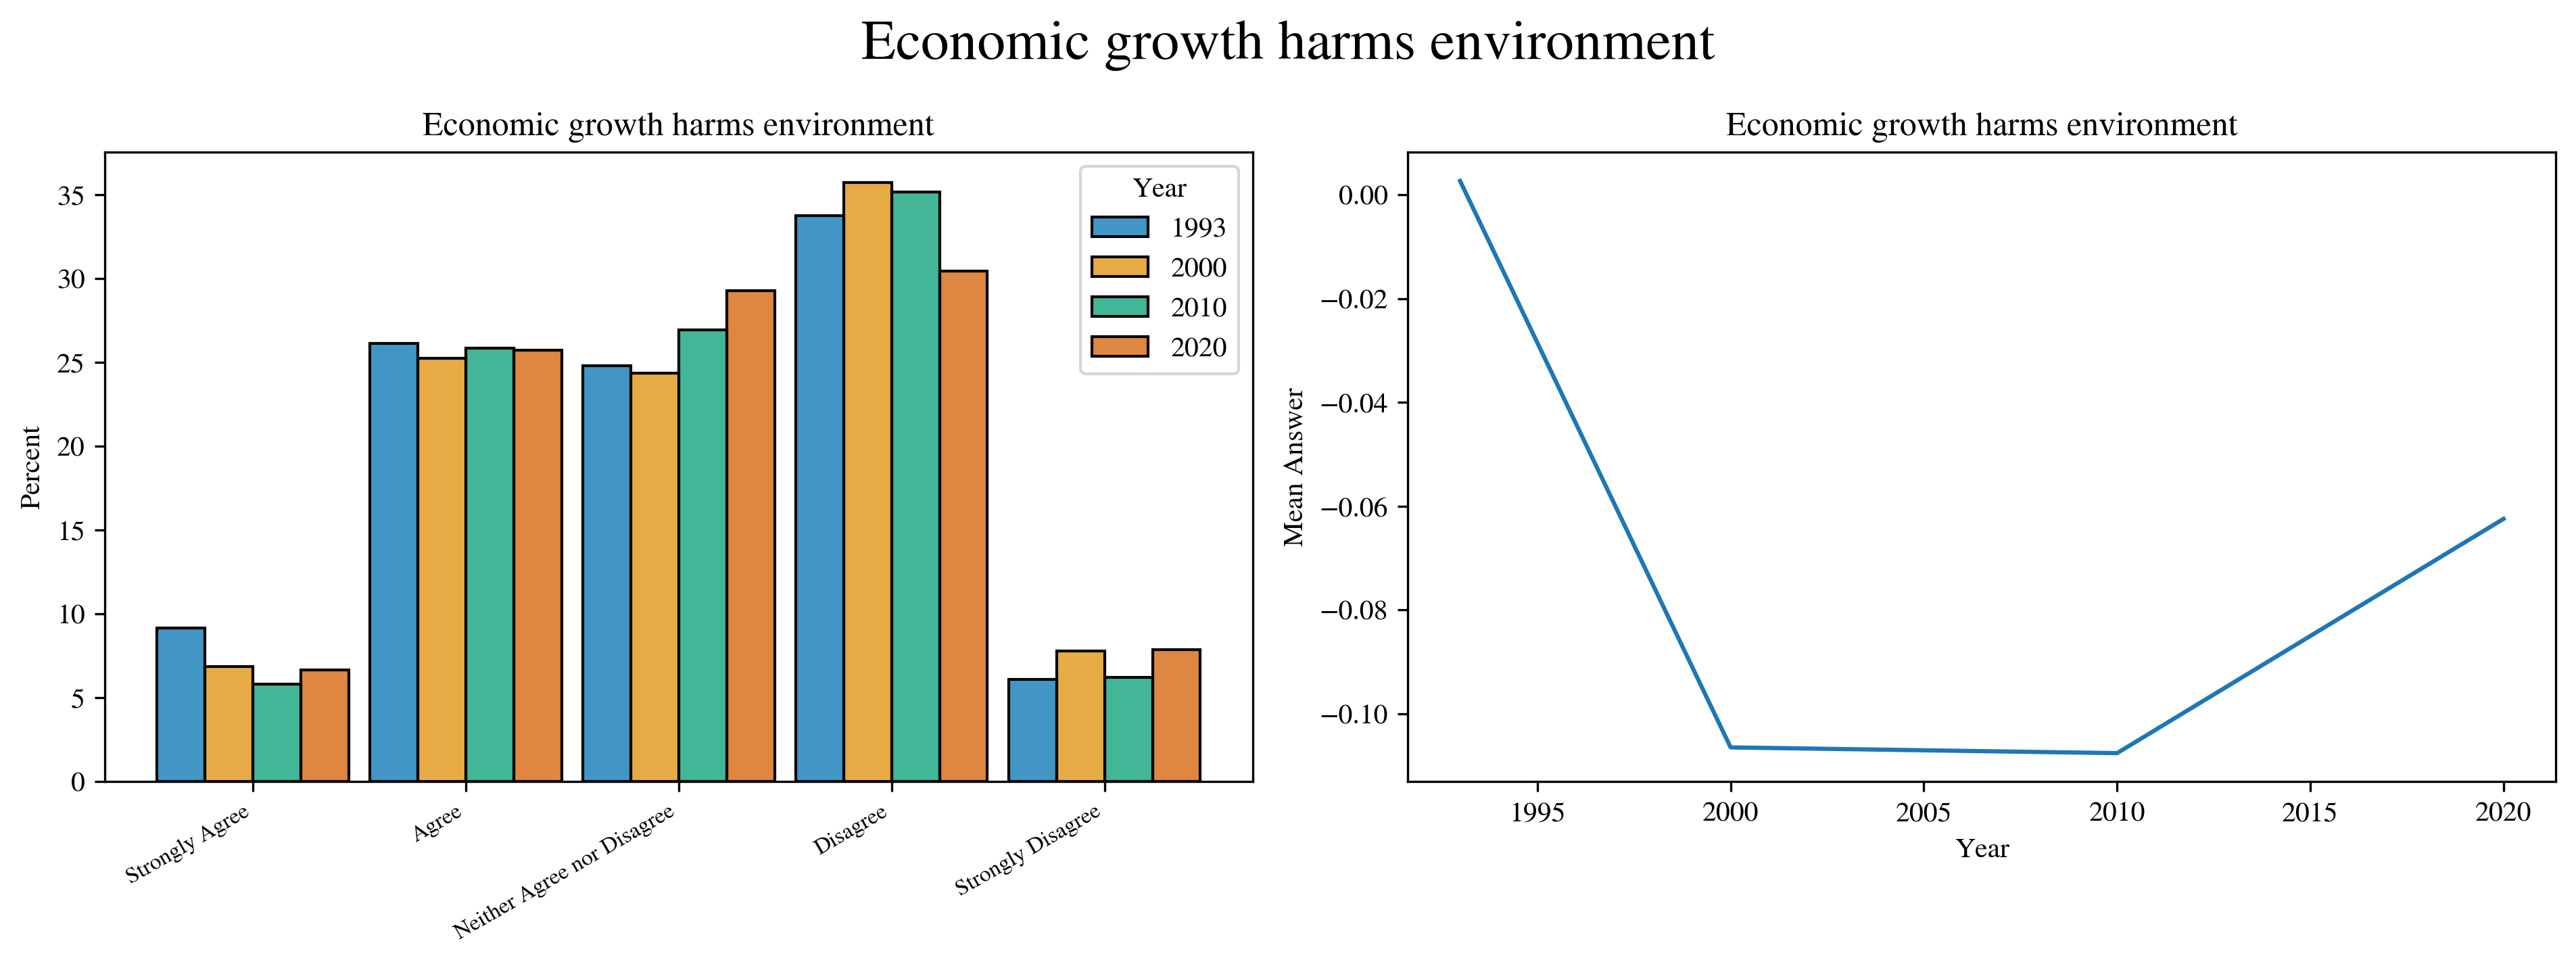

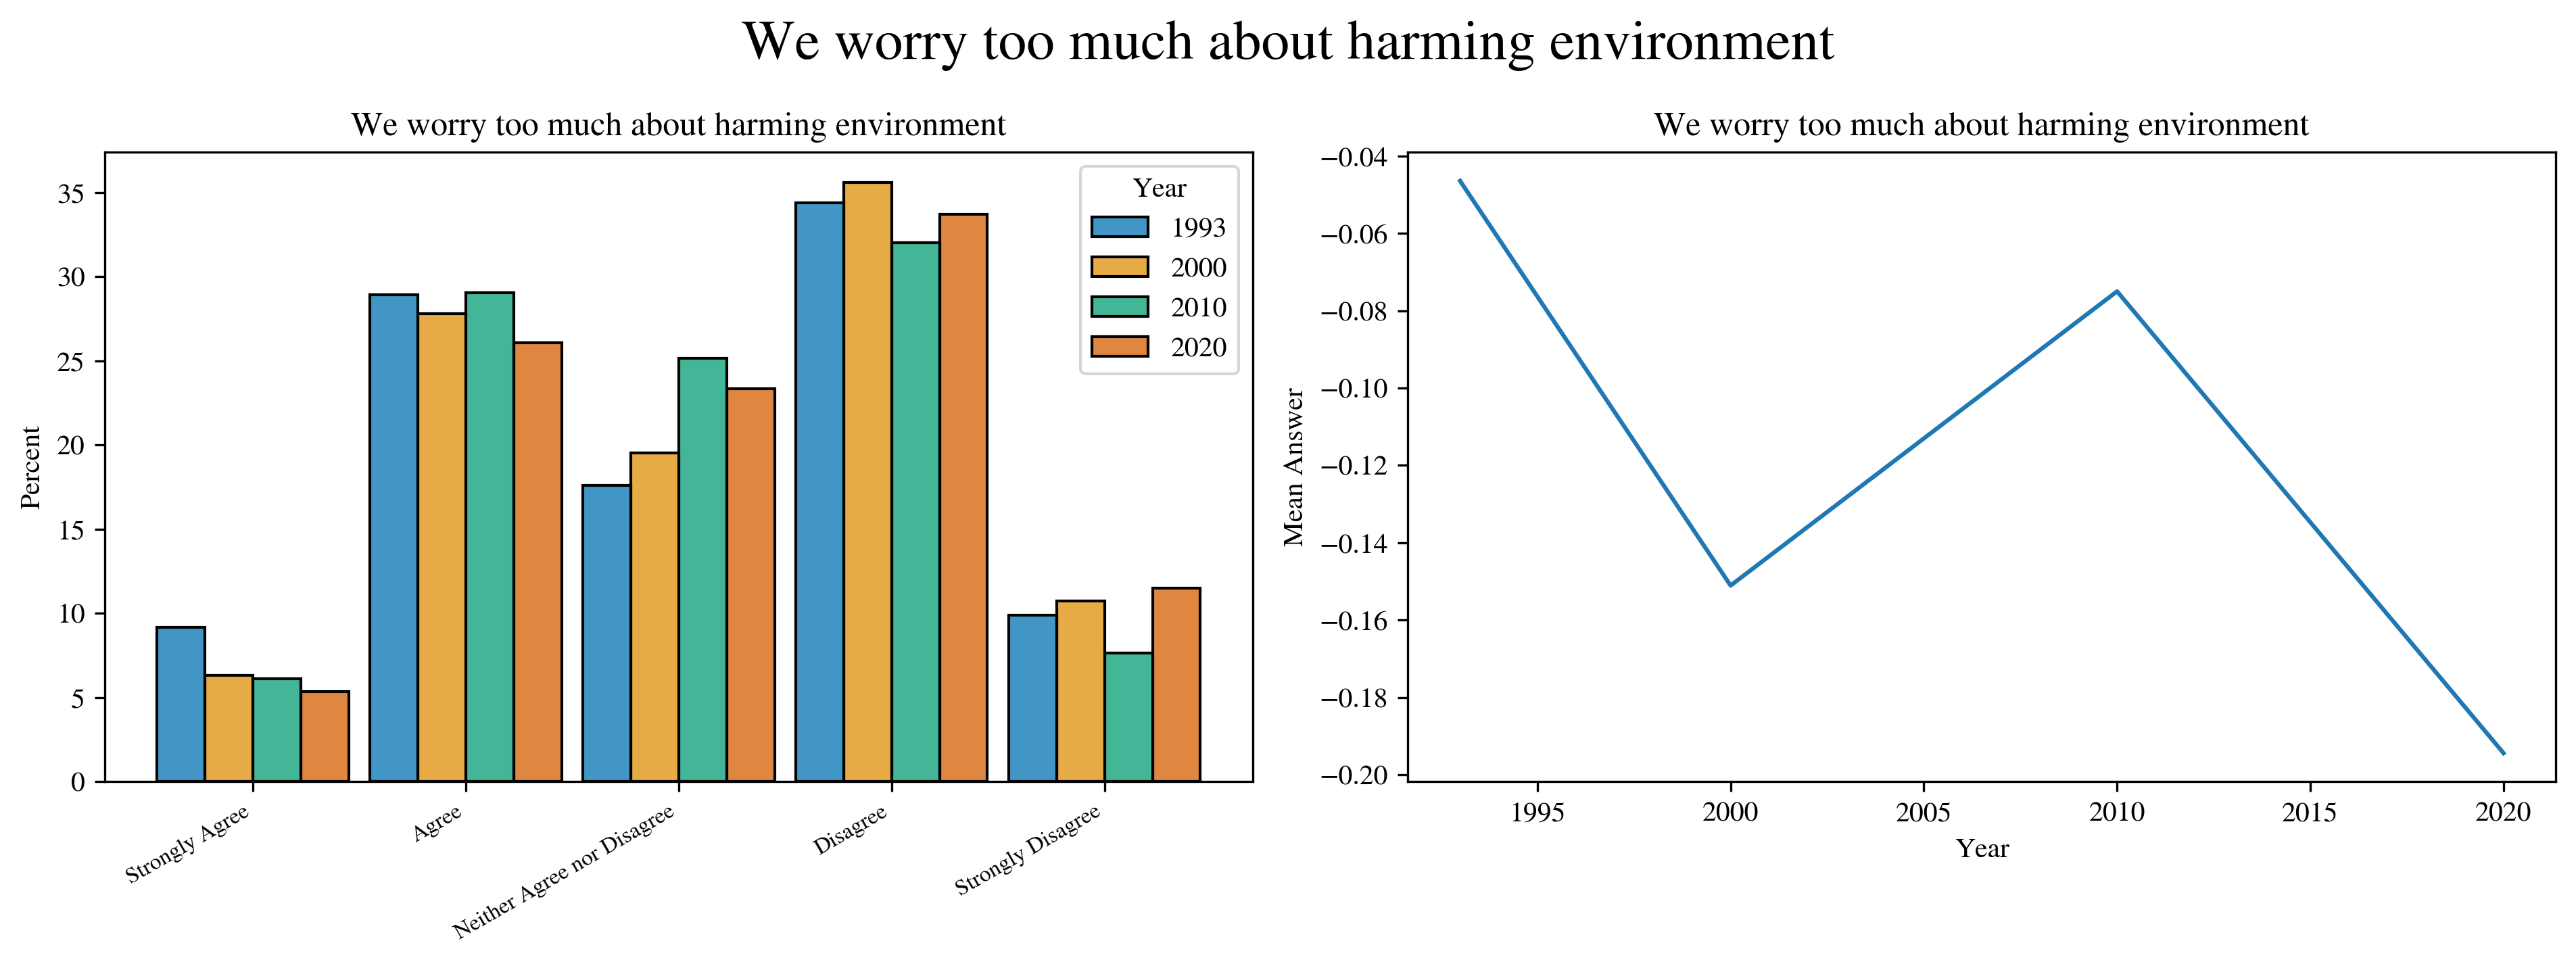

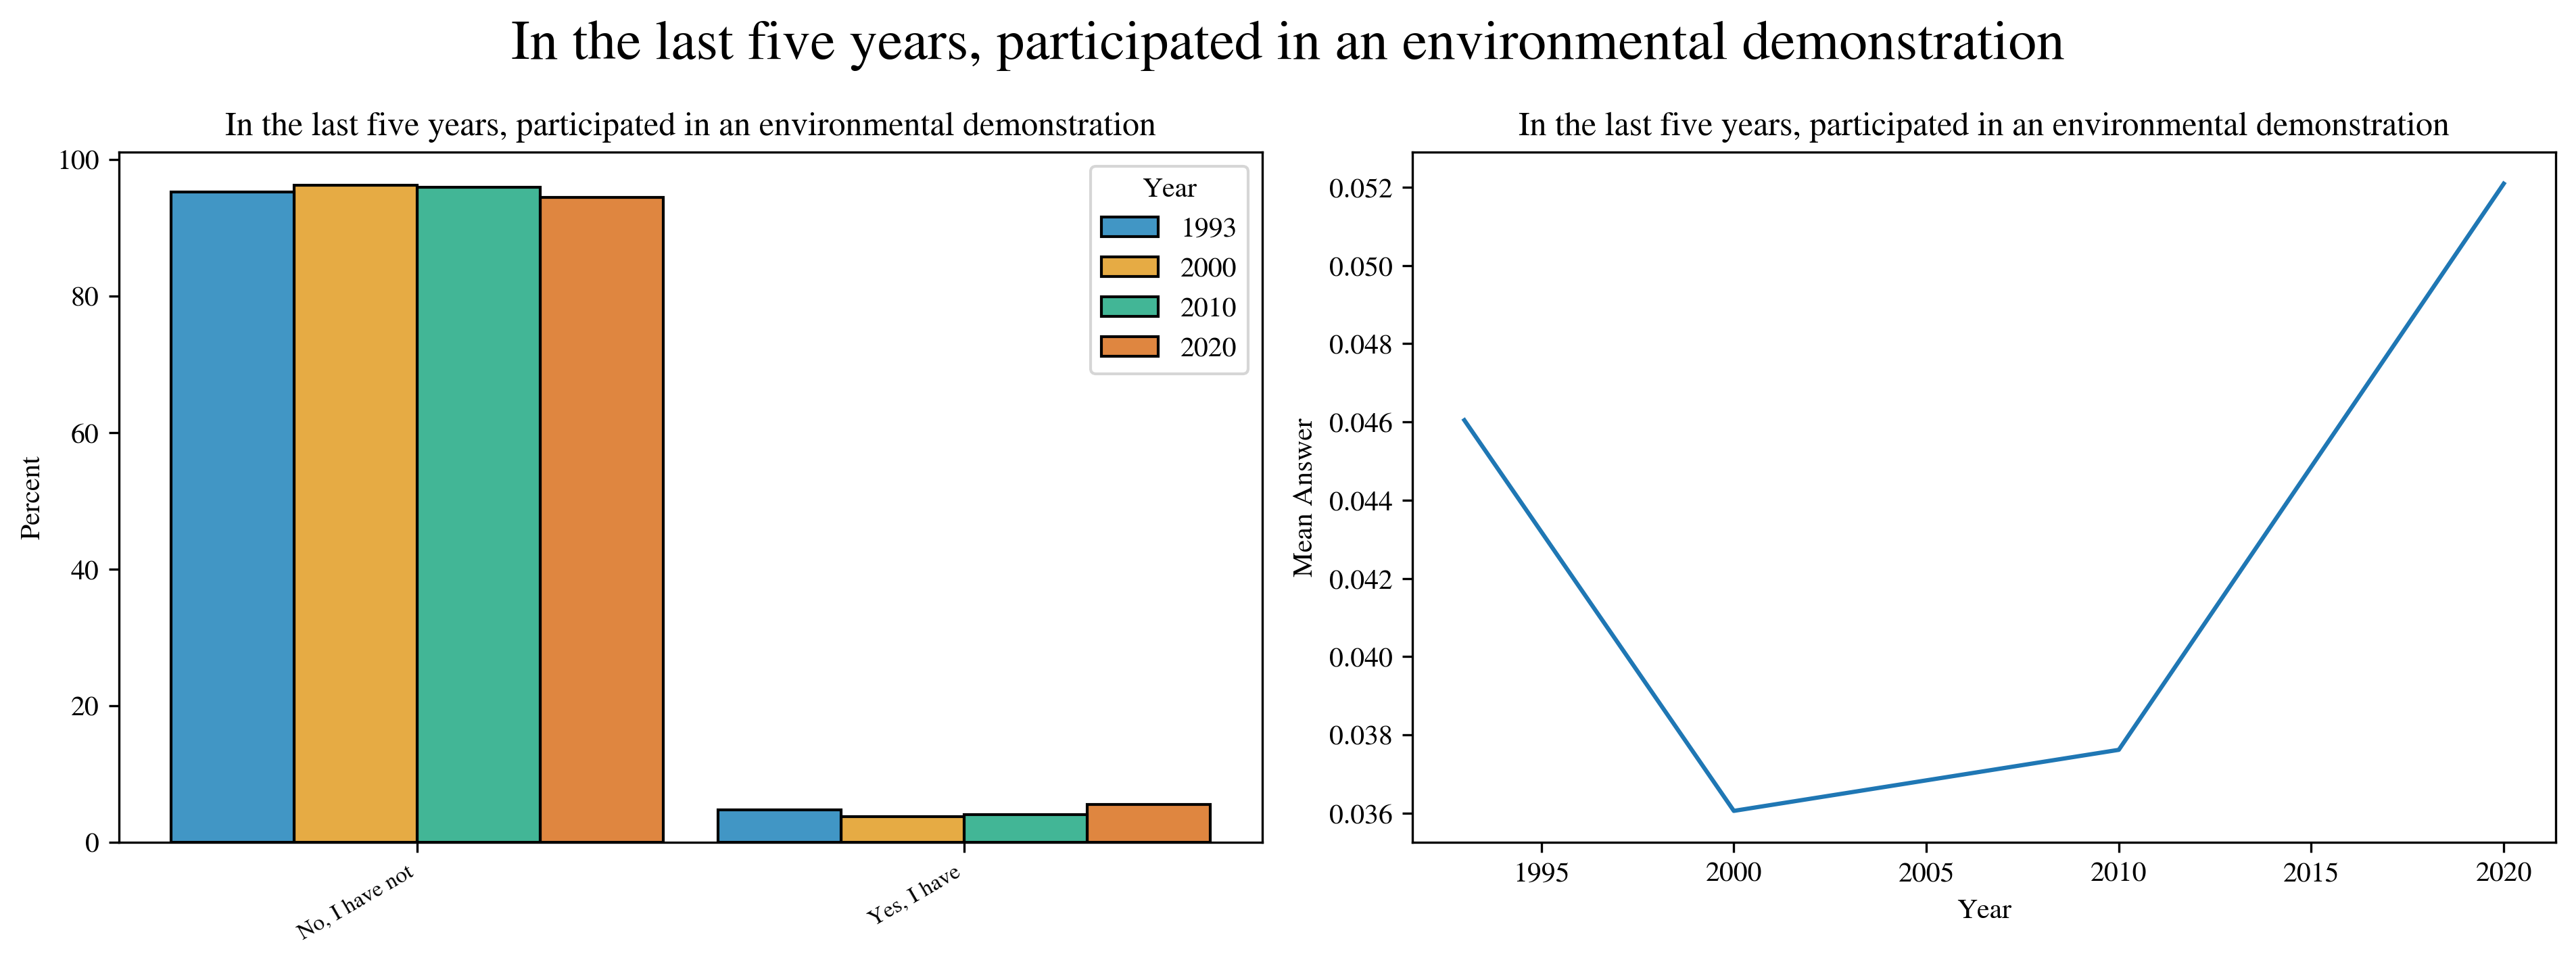

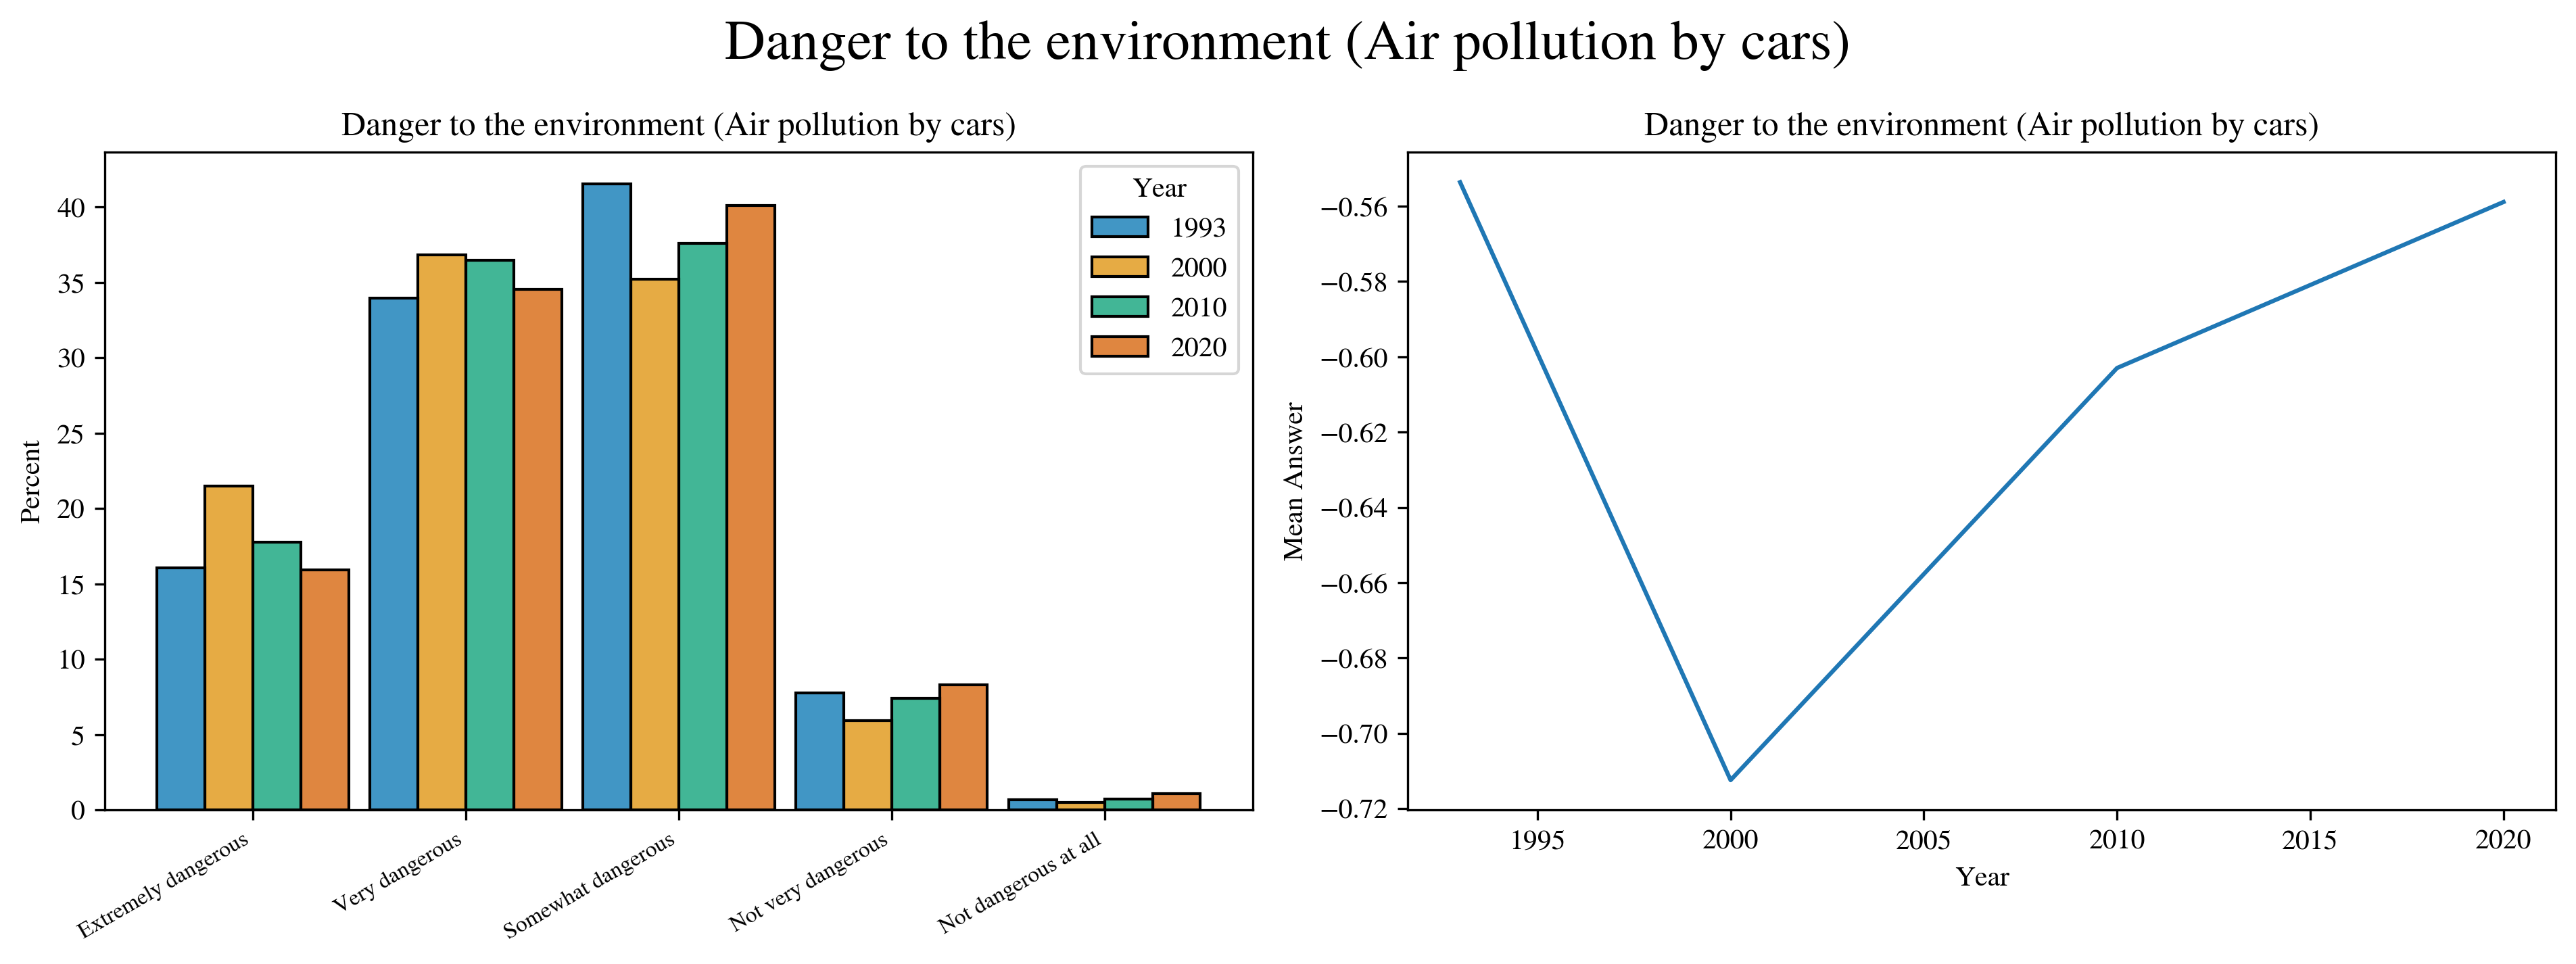

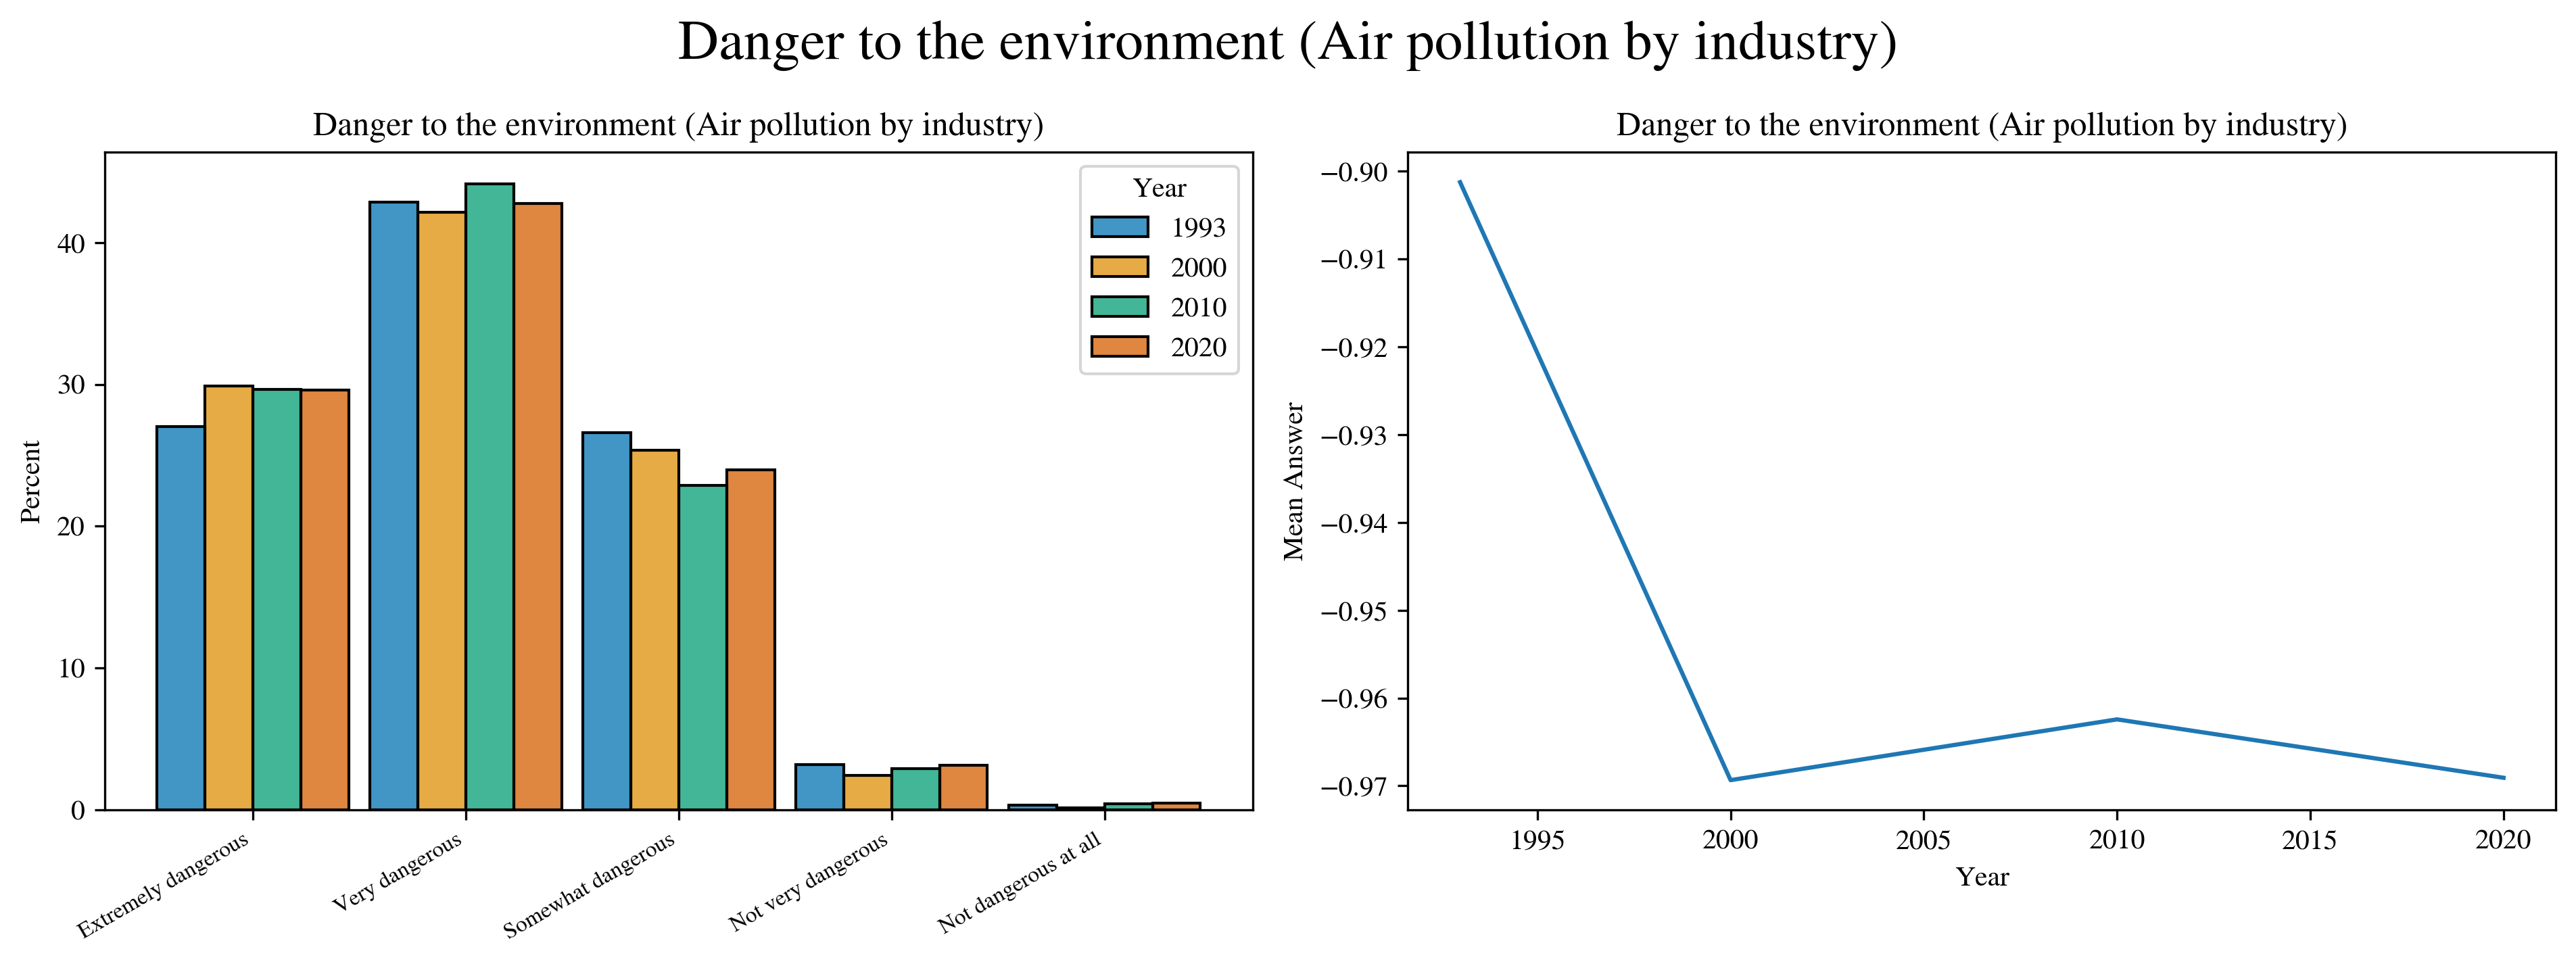

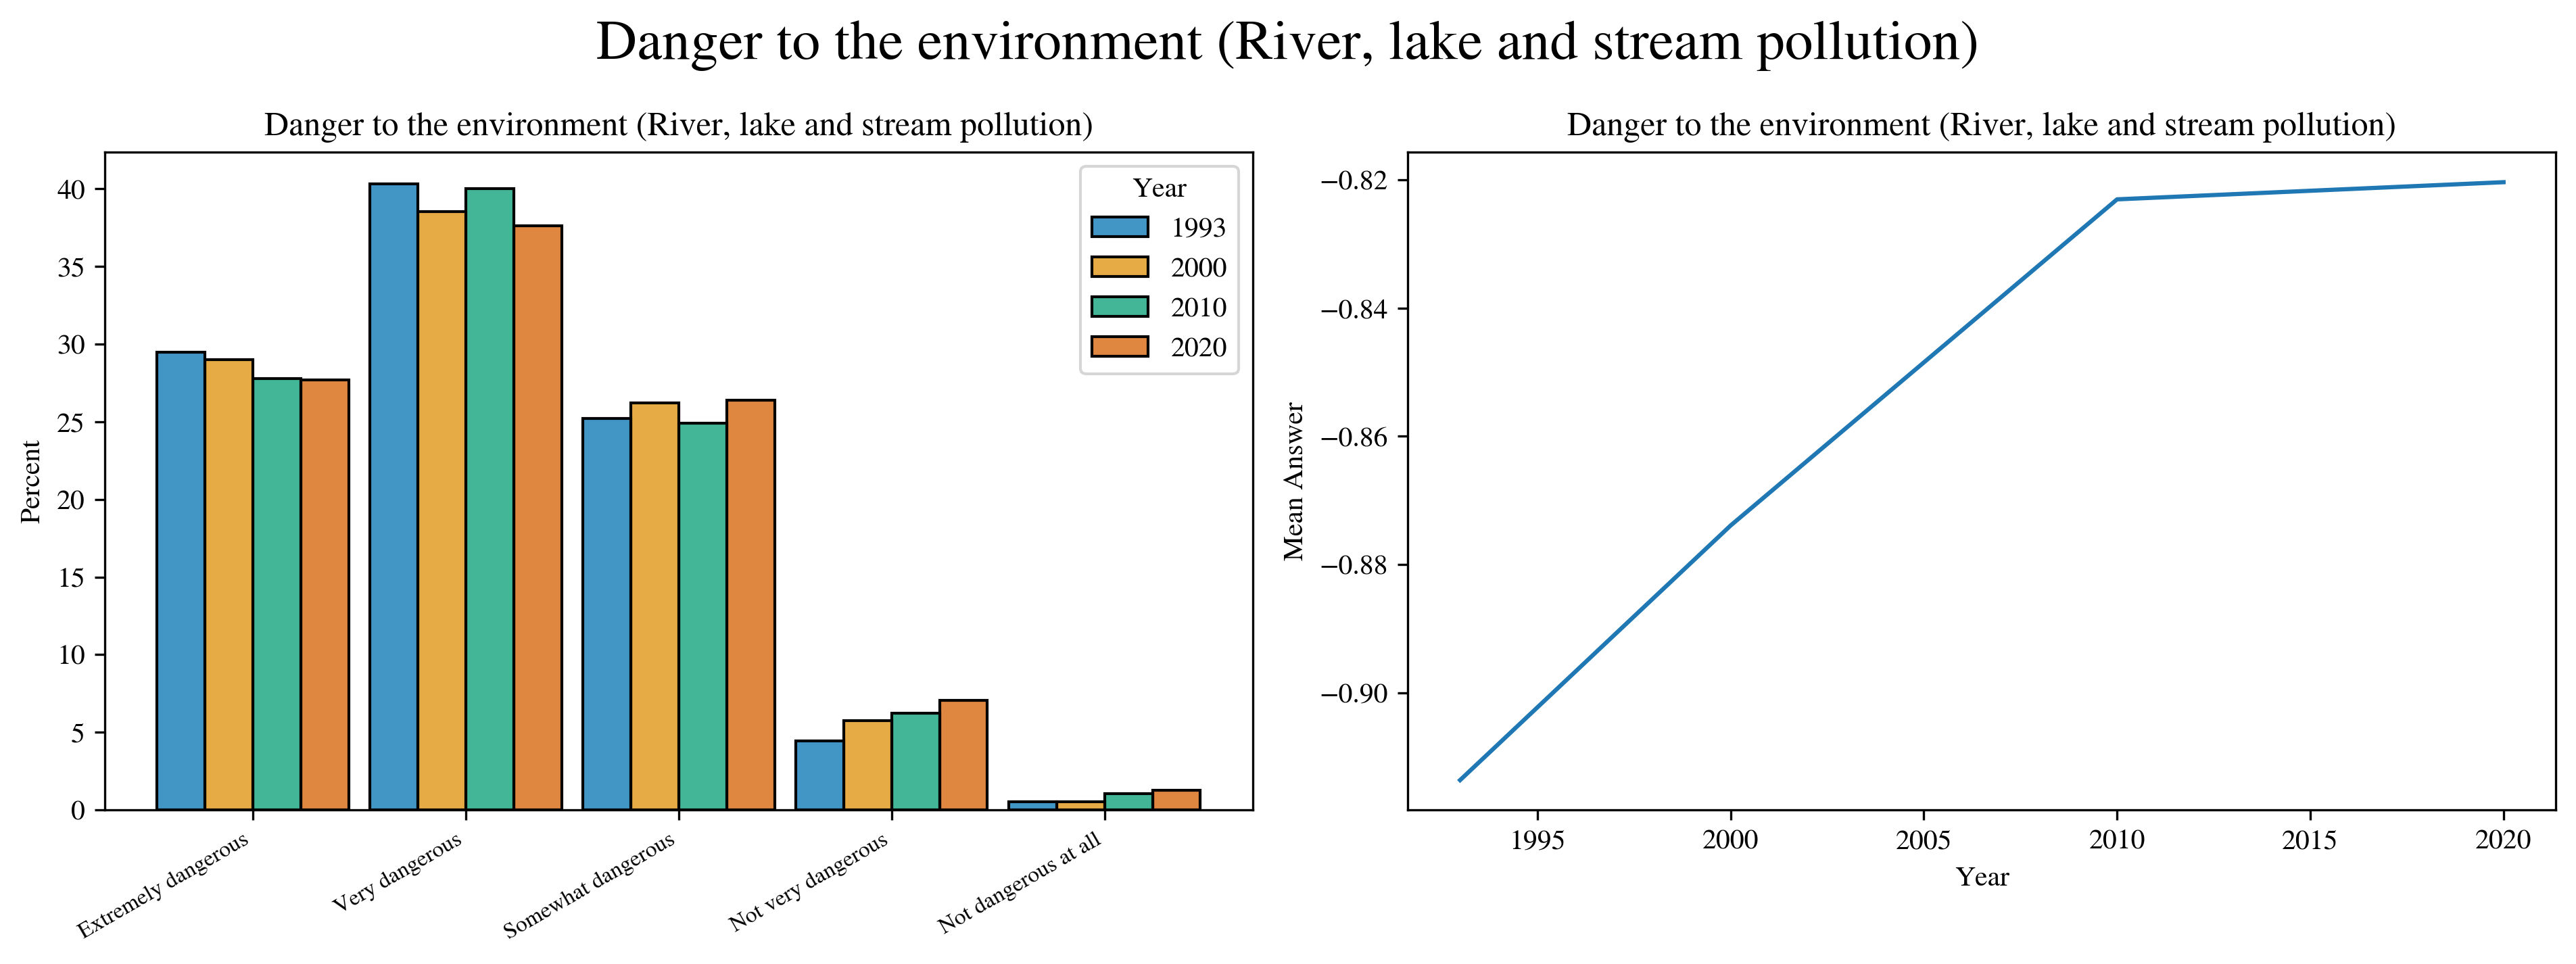

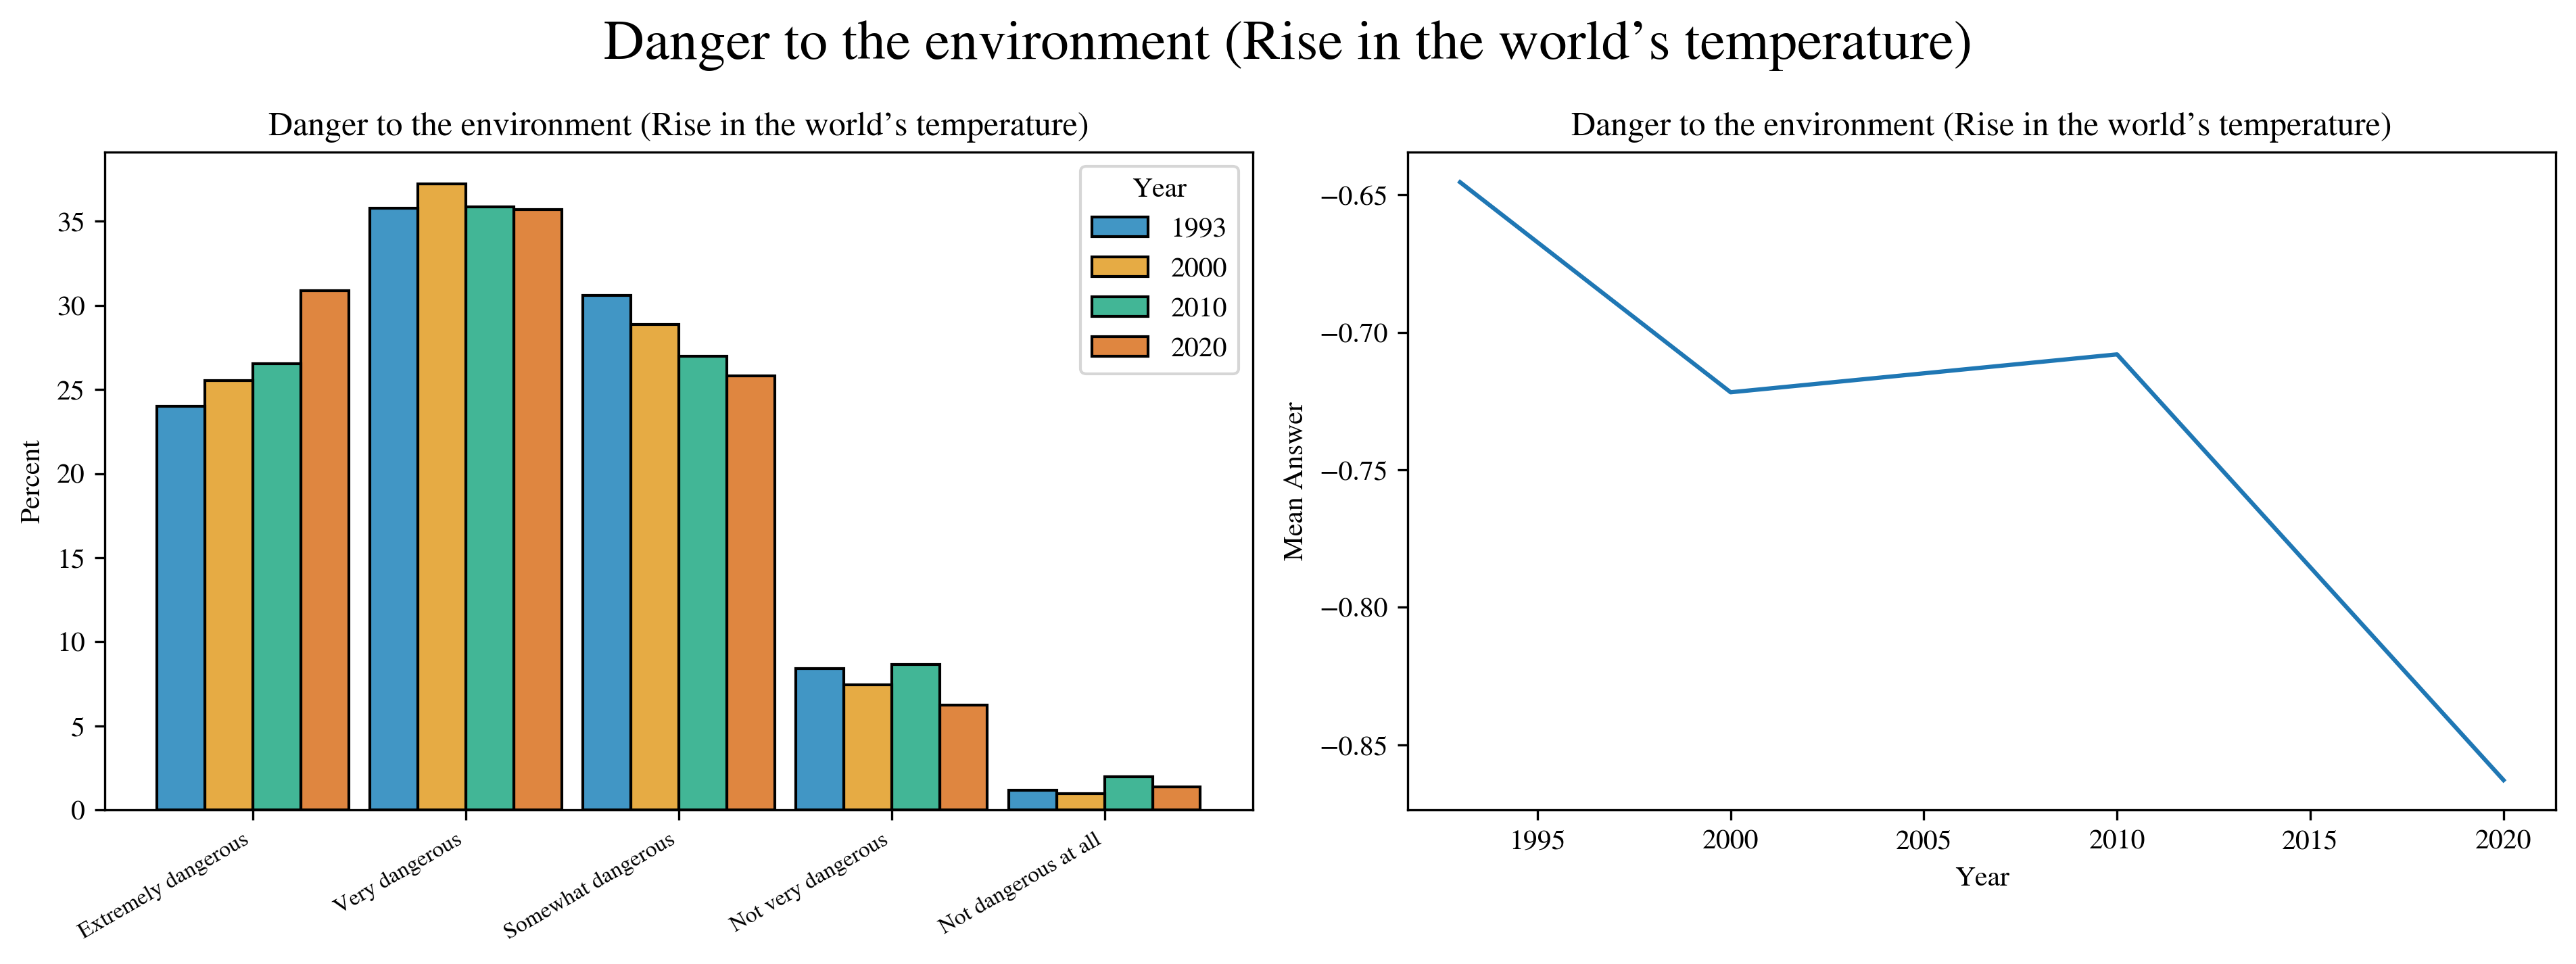

In [29]:
#plotting data
cols = [
    #economy vs environment (link to economic growth)
    'Environmental protection needs economic growth', 'Economic growth harms environment', 
    #environmental activism (link to policy implementation in different states)
    'We worry too much about harming environment', 'In the last five years, participated in an environmental demonstration',
    #perception of danger to environment (link to actual environmental data -> pollution levels / deaths because of pollution...)
    'Danger to the environment (Air pollution by cars)', 'Danger to the environment (Air pollution by industry)', 'Danger to the environment (River, lake and stream pollution)',
    #climate change (link to countries most affected by climate change -> extreme climate events...?
    'Danger to the environment (Rise in the world’s temperature)'
]
        

#cols = list(data_issp.columns.drop(["Country", "Respondent ID", "Weight", "year"])) #uncomment to plot all columns



data = data_issp[cols].copy()
data = data.map(conv_answers).astype(float)
data = data.mul(data_issp["Weight"], axis="index").groupby(["Year", "Country"]).sum().div(data_issp["Weight"].groupby(["Year", "Country"]).sum(), axis="index")


for i,col in enumerate(cols):
    fig, axs = plt.subplots(1,2, figsize=(6.4*2,4.8))
    fig.suptitle(col, fontsize=20)
    
    sns.histplot(data=data_issp.reset_index(), x=col, hue="Year", stat="percent", shrink=0.9, multiple="dodge", palette="colorblind", common_norm=False, ax=axs[0])

    axs[0].set_title(col)
    axs[0].set_xlabel("")
    for tick in axs[0].get_xticklabels():
        tick.set_fontsize(8)
        tick.set_horizontalalignment('right')
        tick.set_rotation(30)
    
    sns.lineplot(data=data.groupby("Year").mean().reset_index(), x="Year", y=col, ax=axs[1])
    axs[1].set_title(col)
    axs[1].set_ylabel("Mean Answer")
    
    plt.tight_layout()

del(data)

___
# Economy and environment

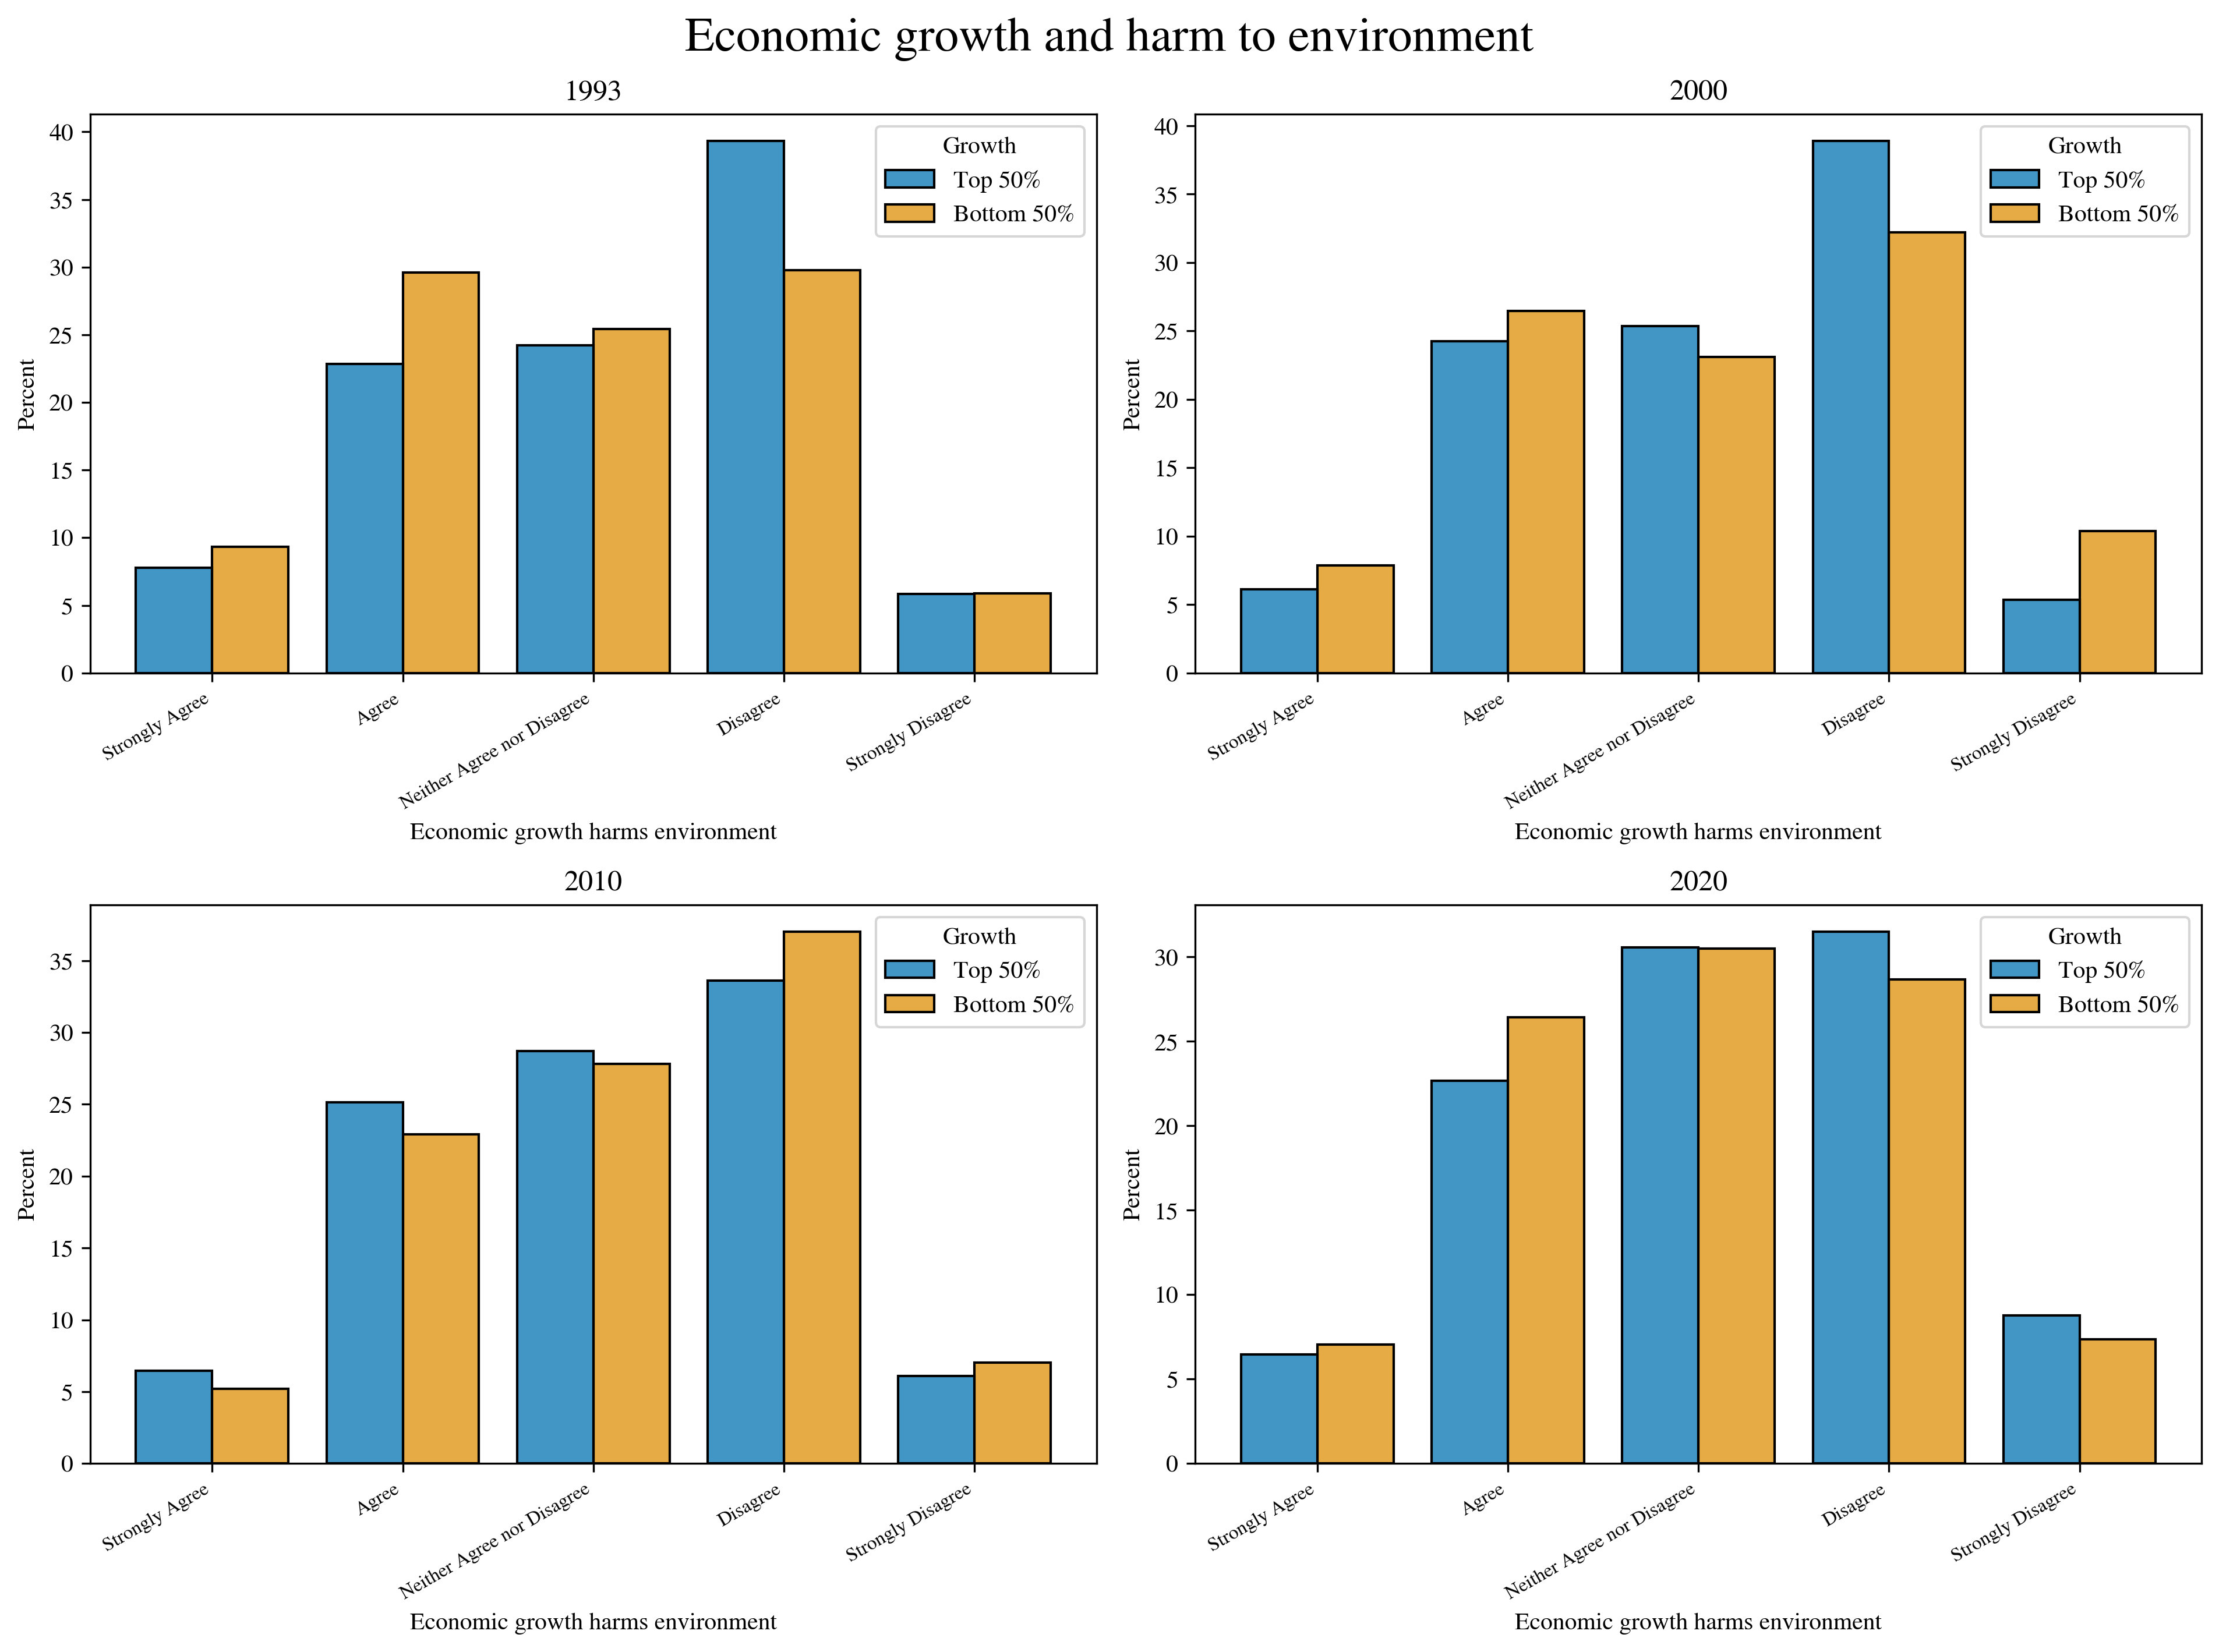

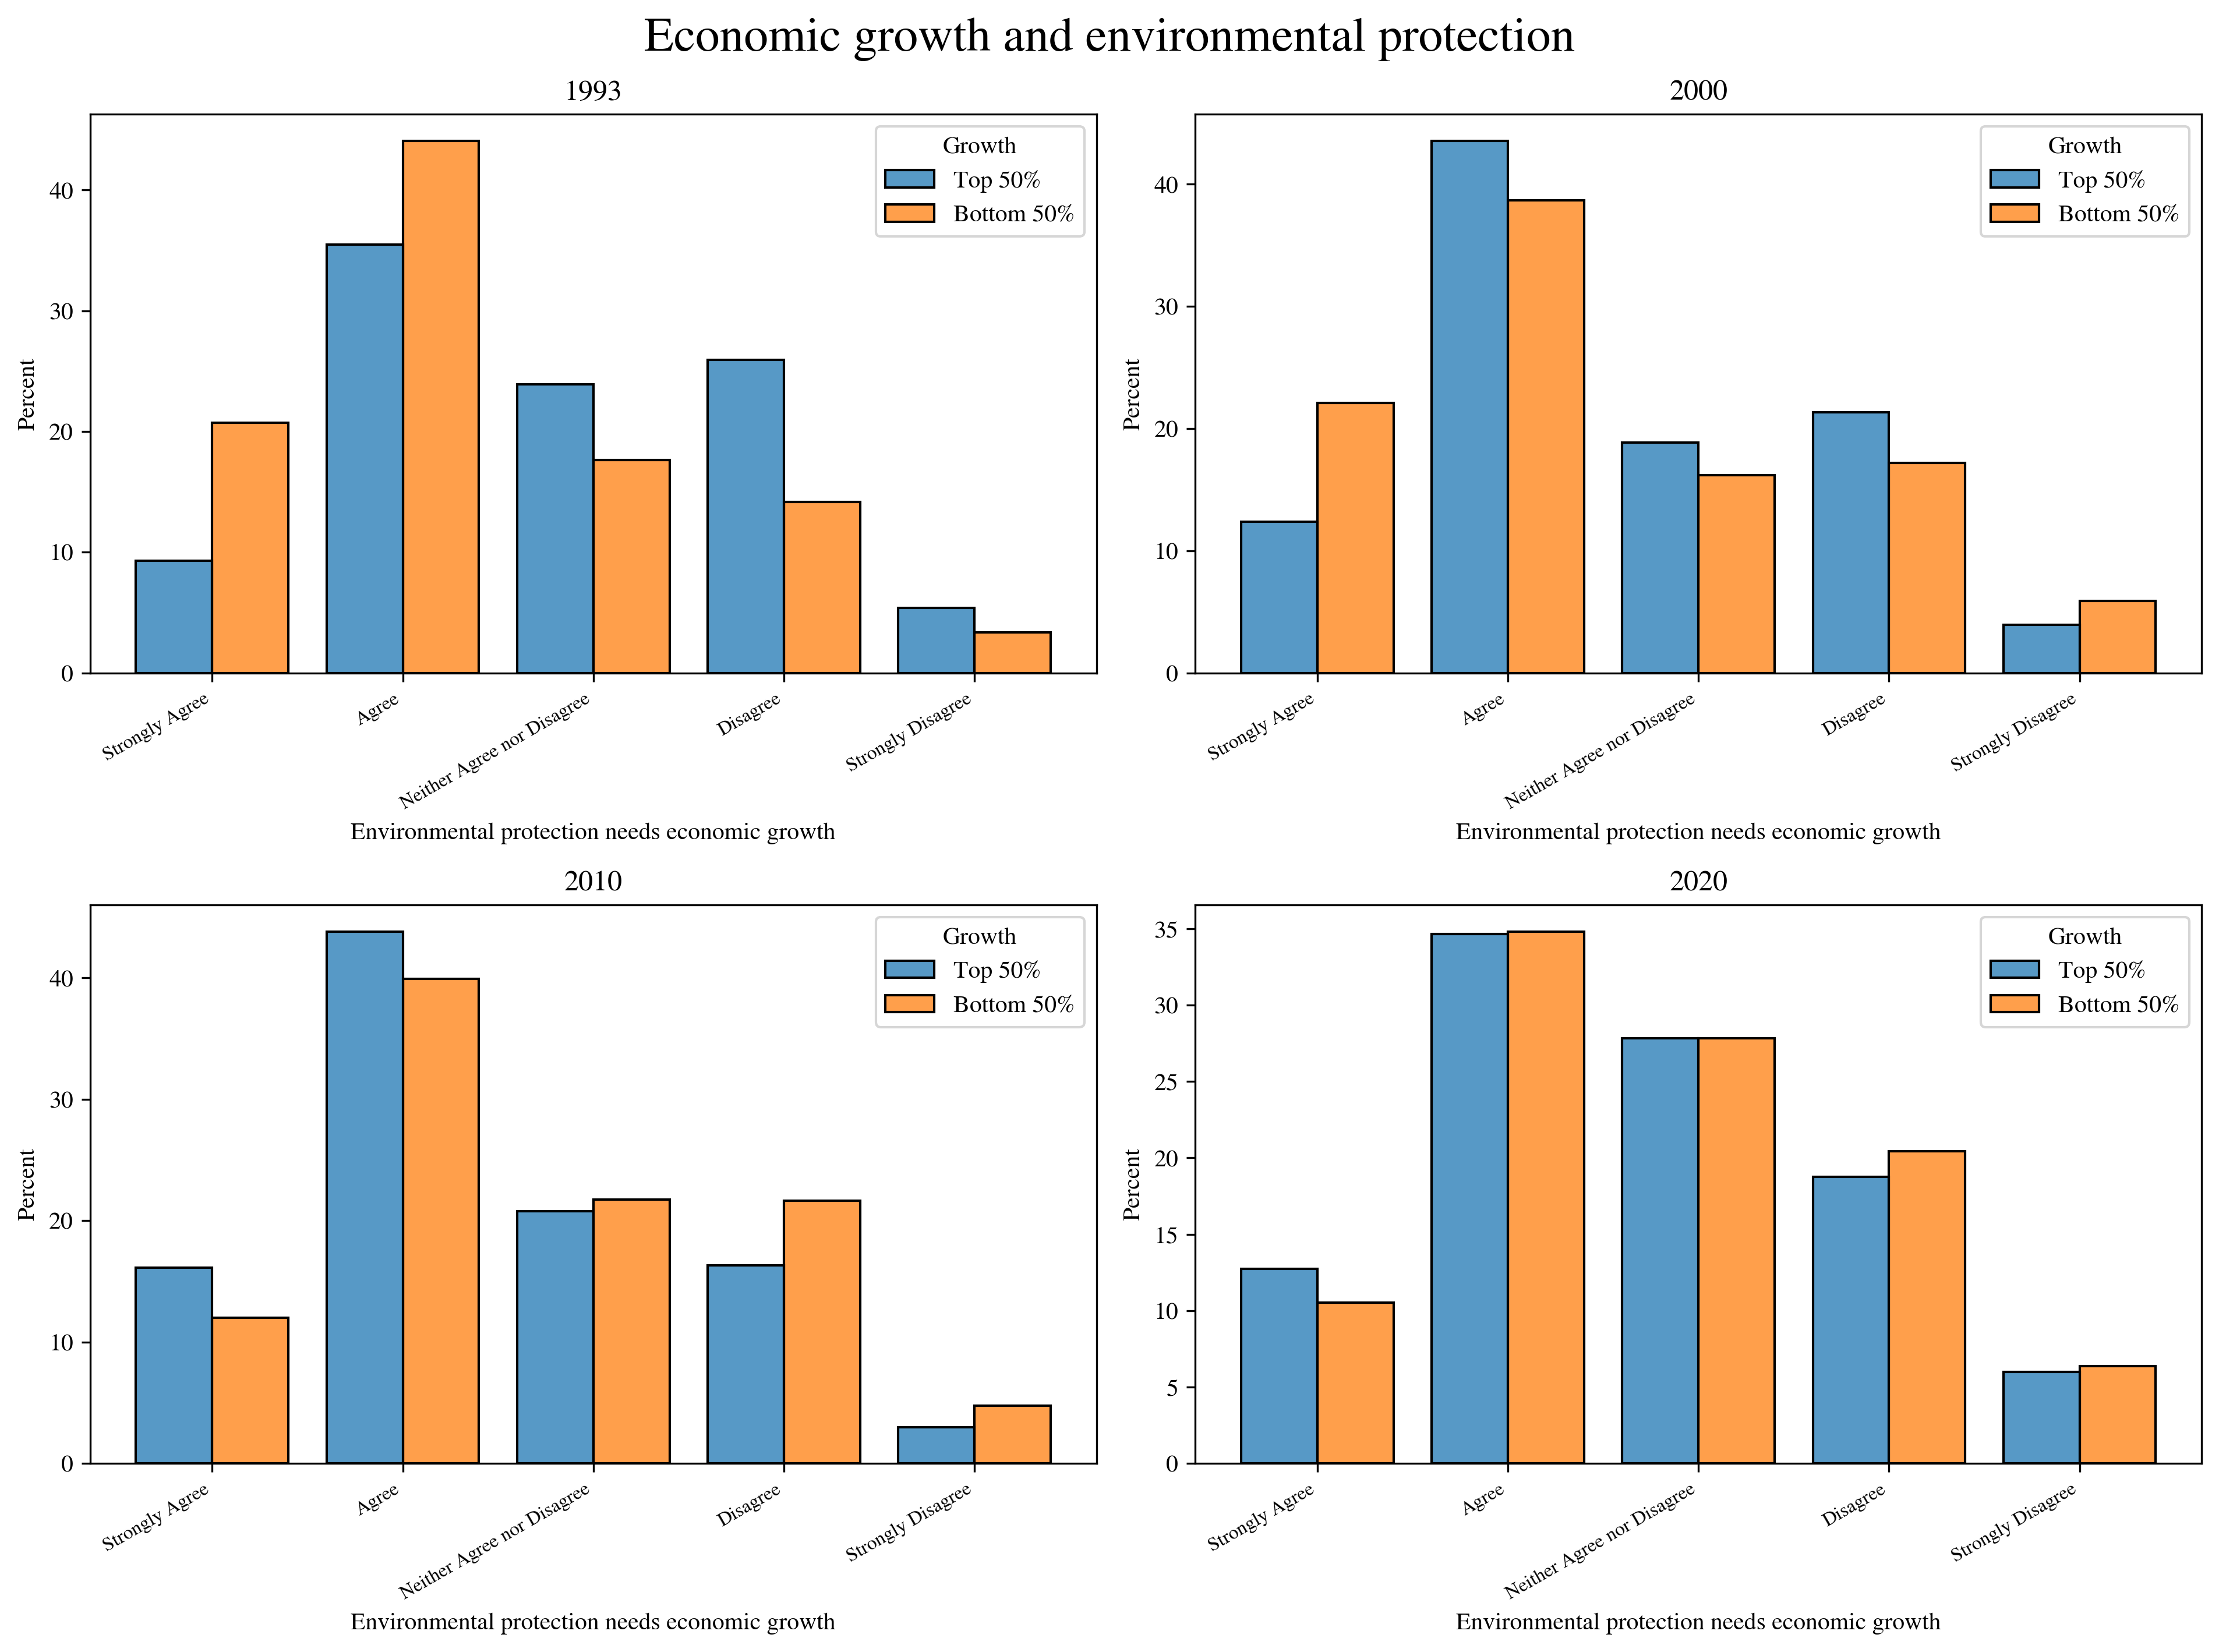

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(6.4*2,4.8*2))
fig.suptitle("Economic growth and harm to environment", fontsize=20)

for i, year in enumerate([1993,2000,2010,2020]):
    growing_countries = [c for c in data_GDPgrowth.index.drop("World") if data_GDPgrowth.loc[c, year] >= data_GDPgrowth.drop(index="World")[year].median()]

    ax = axs[i//2,i%2]
    data = data_issp.loc[(year, slice(None)),:].reset_index().copy()
    data["Growth"] = data["Country"].map(lambda x: "Top 50%" if x in growing_countries else "Bottom 50%")
    data = data.sort_values("Growth", axis=0, ascending=False)
    sns.histplot(data=data.query("Country != 'Taiwan'"), x="Economic growth harms environment", hue="Growth", weights="Weight", common_norm=False, multiple="dodge", stat="percent", shrink=0.8, palette="colorblind", ax=ax)
    ax.set_title(year)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(8)
        tick.set_horizontalalignment('right')
        tick.set_rotation(30)
plt.tight_layout()


fig, axs = plt.subplots(2, 2, figsize=(6.4*2,4.8*2))
fig.suptitle("Economic growth and environmental protection", fontsize=20)

for i, year in enumerate([1993,2000,2010,2020]):
    growing_countries = [c for c in data_GDPgrowth.index.drop("World") if data_GDPgrowth.loc[c, year] >= data_GDPgrowth.drop(index="World")[year].median()]

    ax = axs[i//2,i%2]
    data = data_issp.loc[(year, slice(None)),:].reset_index().copy()
    data["Growth"] = data["Country"].map(lambda x: "Top 50%" if x in growing_countries else "Bottom 50%")
    data = data.sort_values("Growth", axis=0, ascending=False)
    sns.histplot(data=data.query("Country != 'Taiwan'"), x="Environmental protection needs economic growth", hue="Growth", weights="Weight", common_norm=False, multiple="dodge", stat="percent", shrink=0.8, ax=ax)
    ax.set_title(year)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(8)
        tick.set_horizontalalignment('right')
        tick.set_rotation(30)
plt.tight_layout()

del(data)

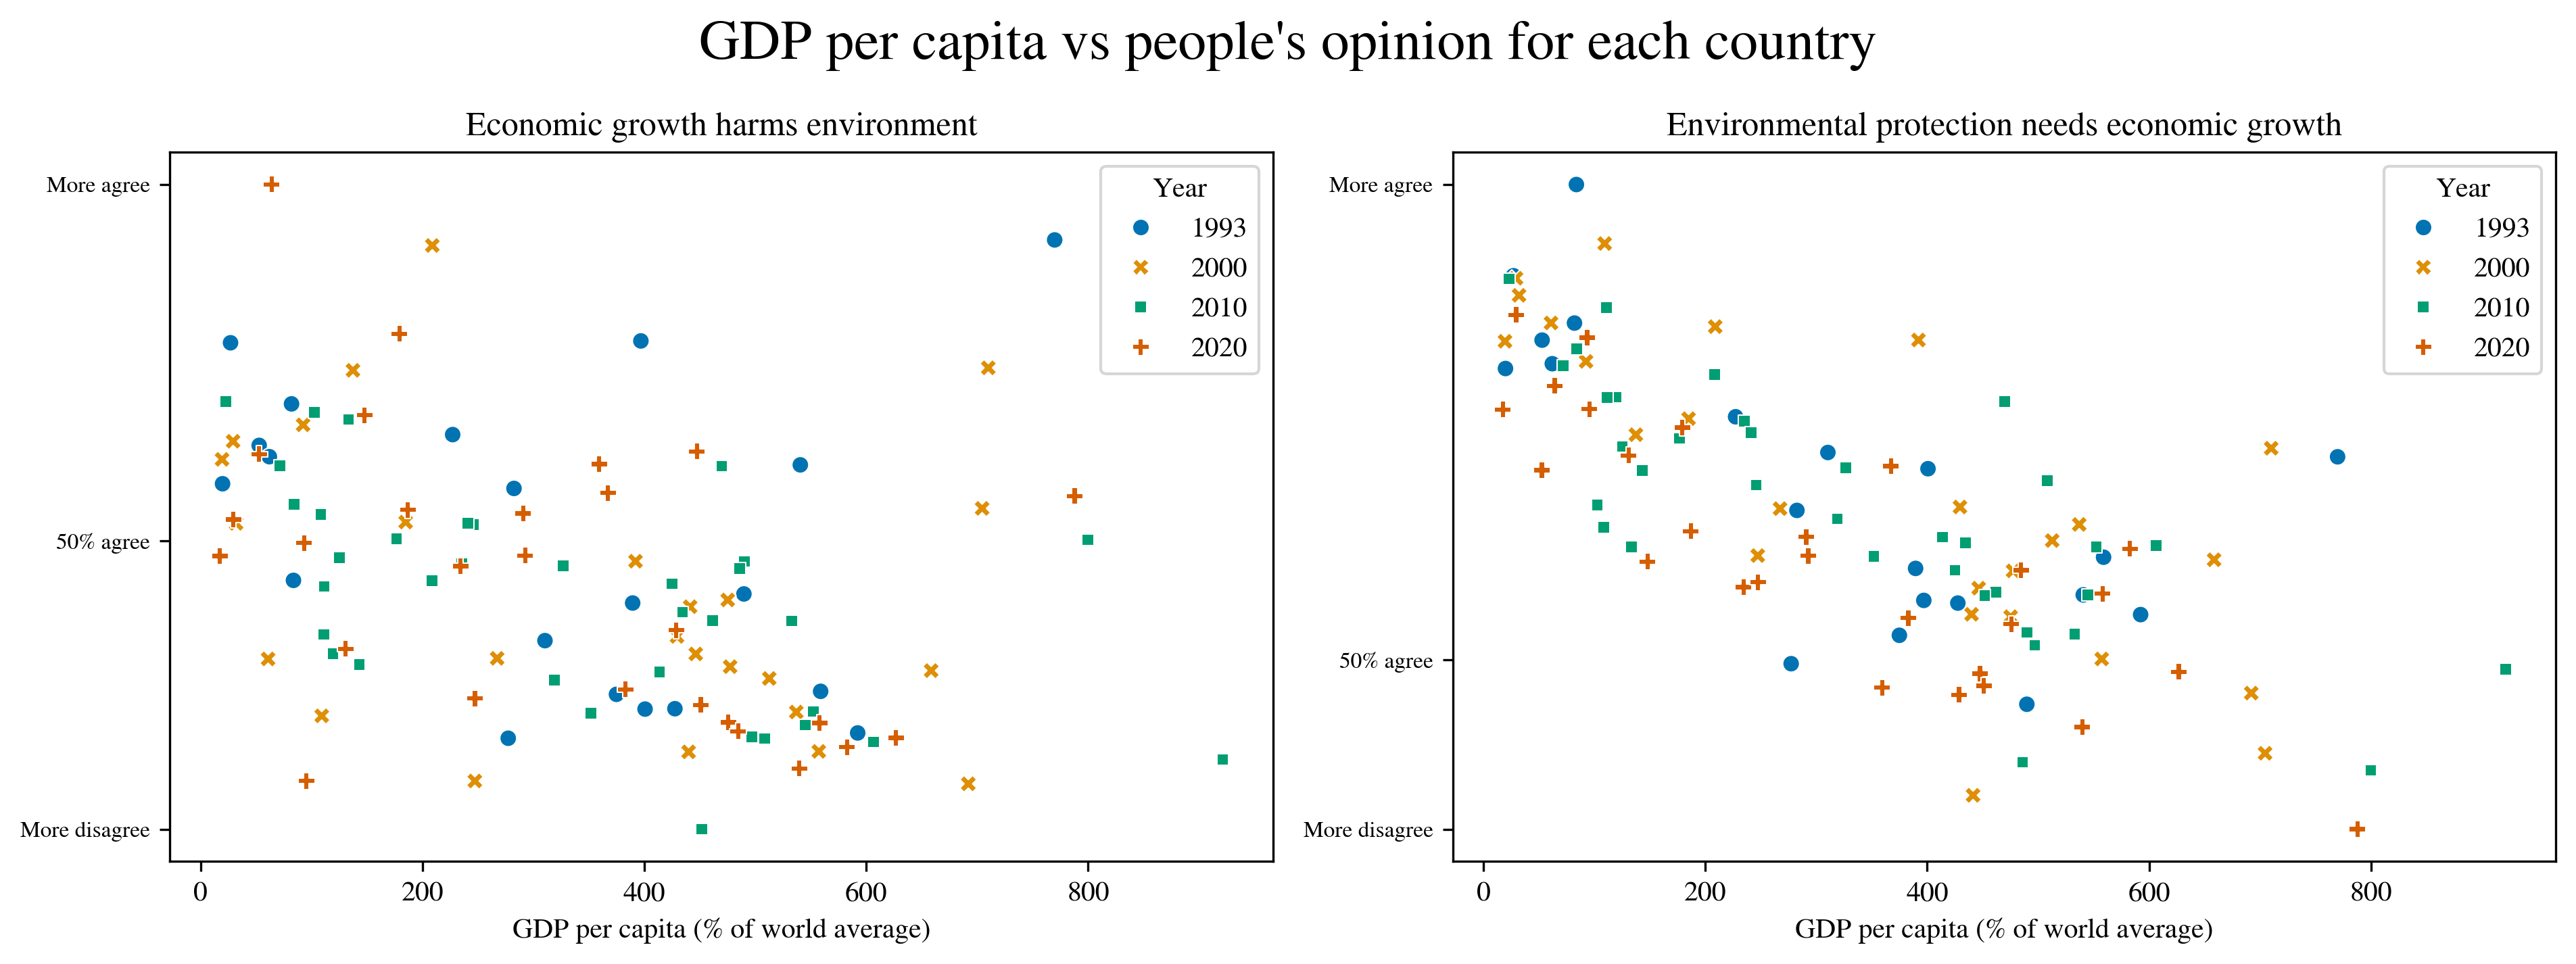

In [7]:
data = data_issp.query("Country != 'Taiwan'").loc[:,["Economic growth harms environment", "Environmental protection needs economic growth", "Weight"]].copy()
data = data.map(conv_answers).astype(float)
data = data[["Economic growth harms environment", "Environmental protection needs economic growth"]].mul(data["Weight"], axis="index").groupby(["Year", "Country"]).sum().div(data["Weight"].groupby(["Year", "Country"]).sum(), axis="index")
data["GDP per capita (% of world average)"] = data.index.map(lambda x: 100*data_GDPpcap.loc[x[1], x[0]].copy() / data_GDPpcap.loc["World",x[0]].copy())


fig, axs = plt.subplots(1,2,figsize=(6.4*2,4.8), sharey=False)
fig.suptitle("GDP per capita vs people's opinion for each country", fontsize=20)

for i, val in enumerate(["Economic growth harms environment", "Environmental protection needs economic growth"]):
    ax = axs[i]
    sns.scatterplot(data=data.reset_index(), x="GDP per capita (% of world average)", y=val, hue="Year", palette="colorblind", style="Year", ax=ax)
    ax.set_title(val)
    ax.set_ylabel("")
    ax.set_yticks([data[val].min(), 0, data[val].max()])
    ax.set_yticklabels(["More disagree", "50% agree", "More agree"], fontsize=8)

plt.tight_layout()

del(data)

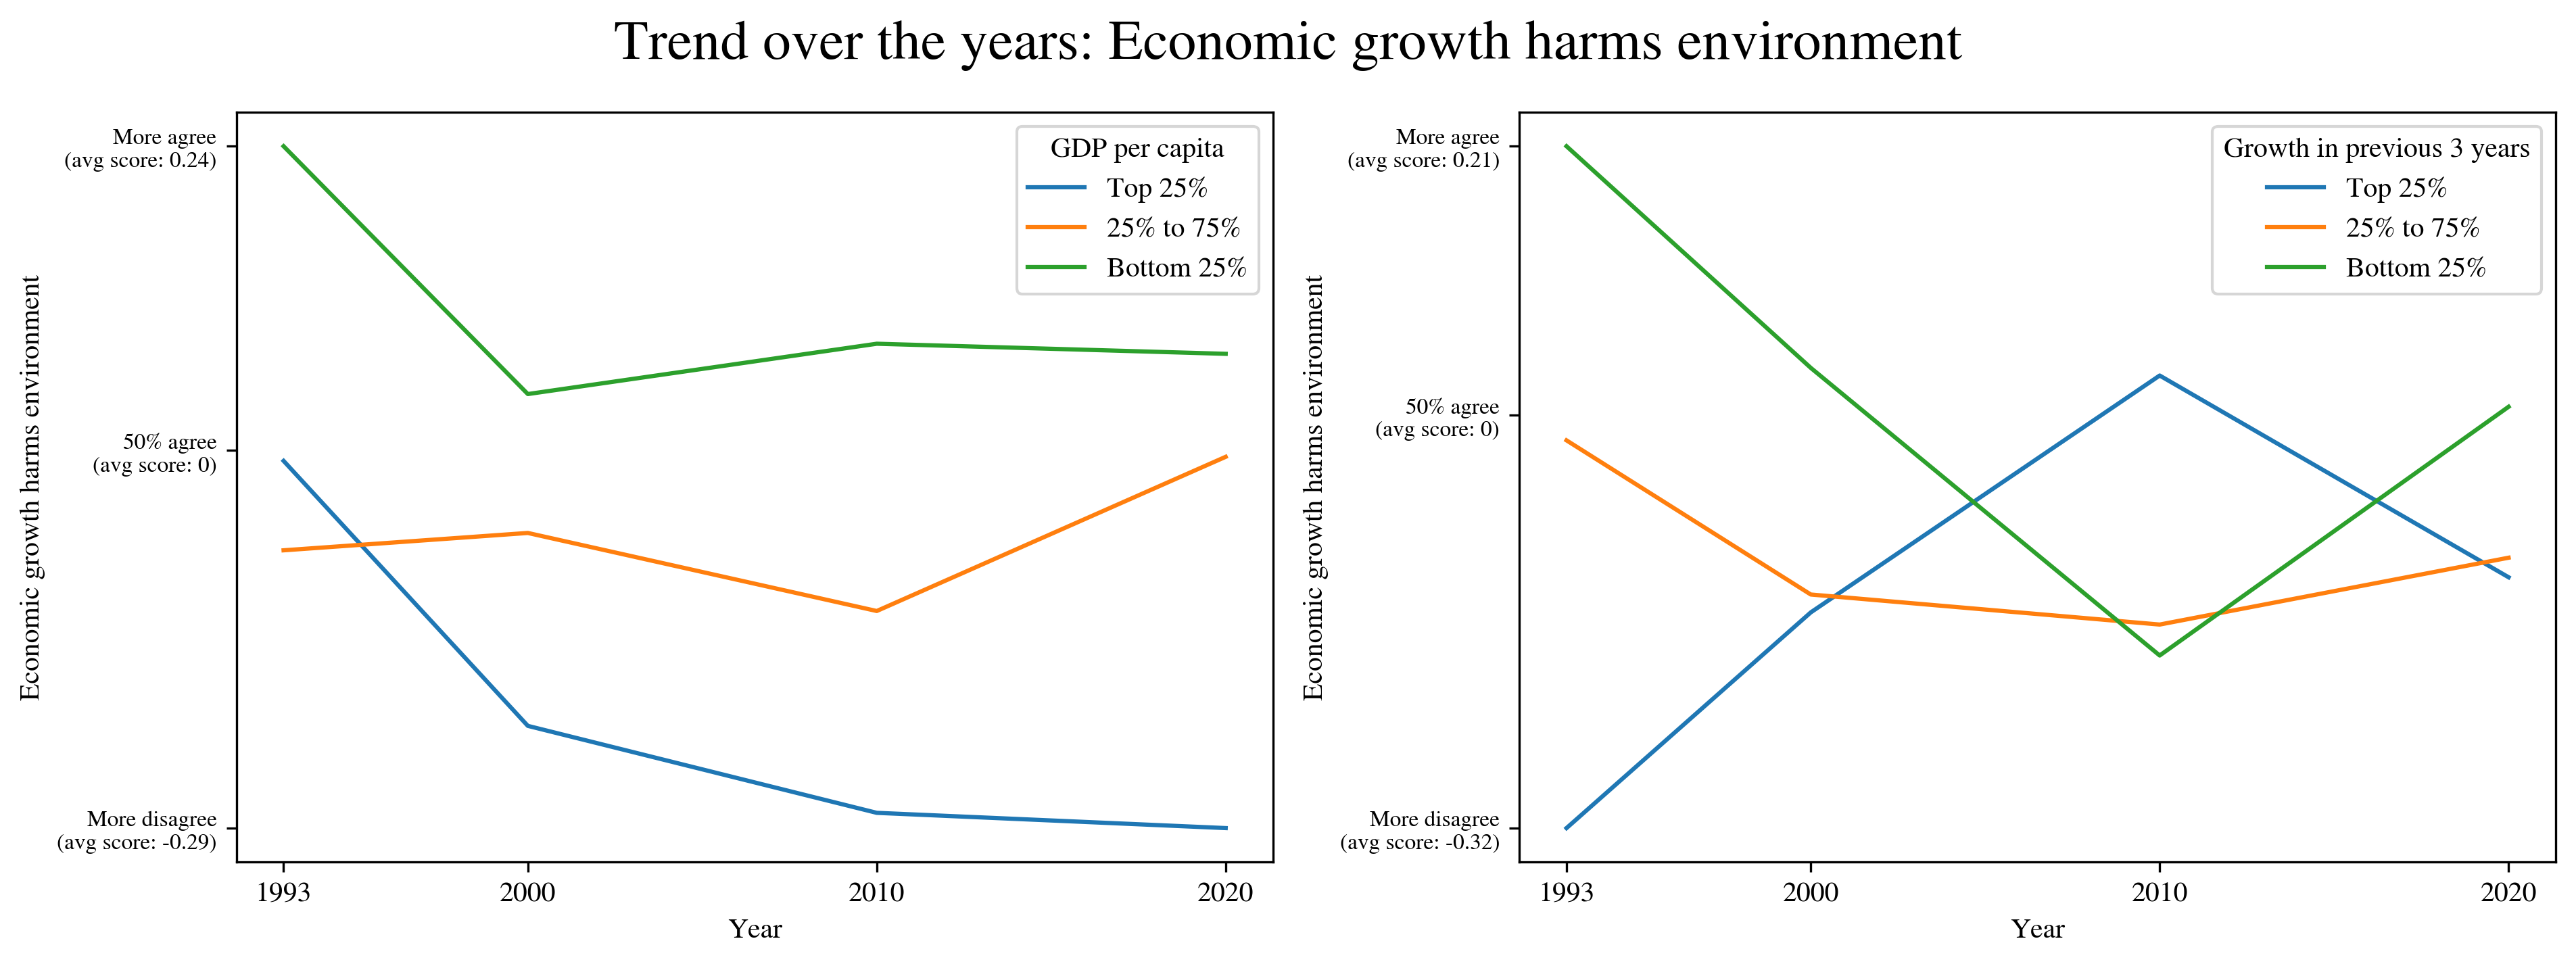

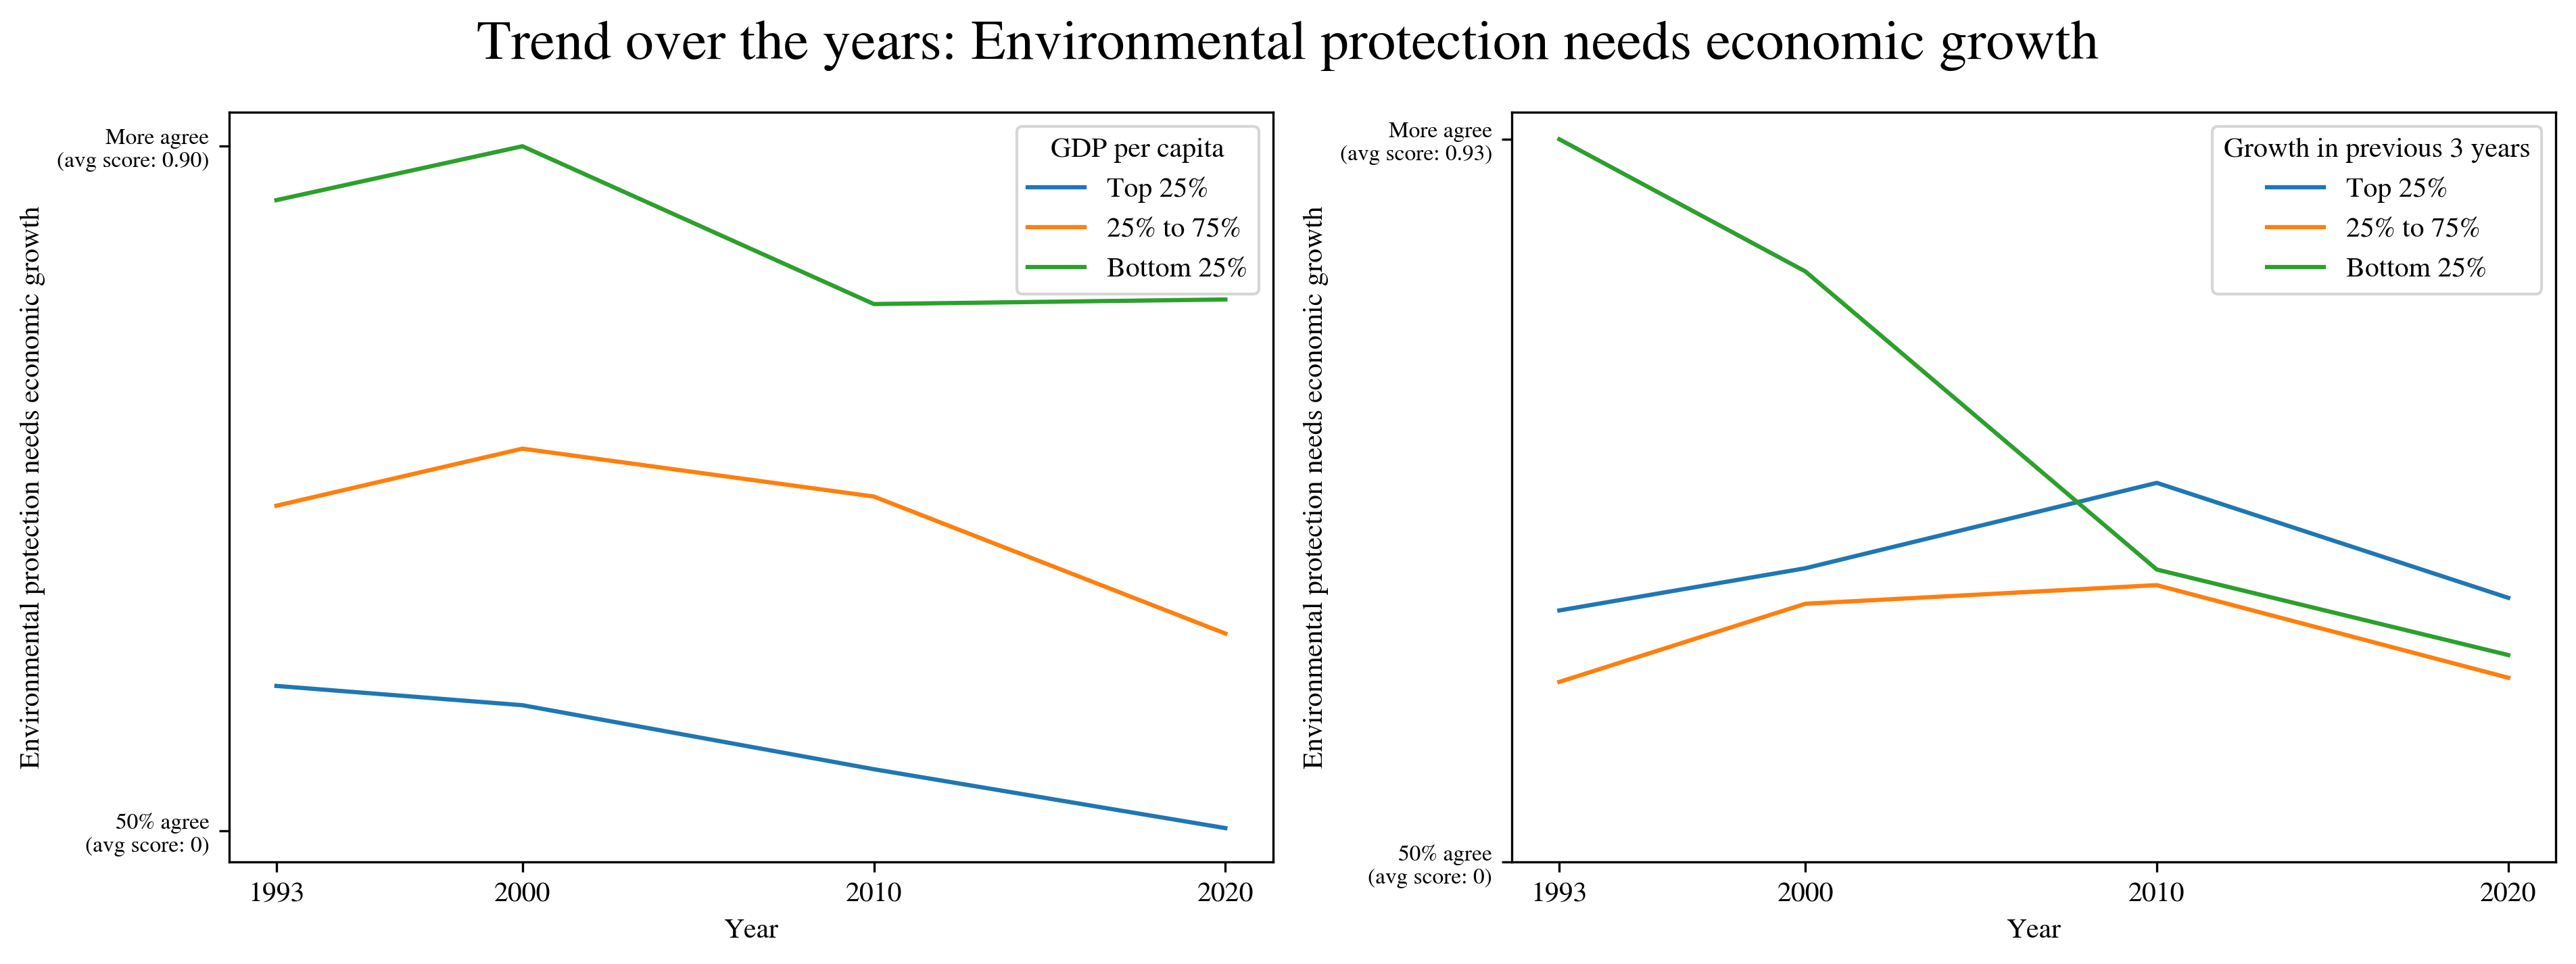

In [8]:
data = data_issp.query("Country != 'Taiwan'").loc[:,["Economic growth harms environment", "Environmental protection needs economic growth", "Weight"]].copy()
data = data.map(conv_answers).astype(float)
data = data[["Economic growth harms environment","Environmental protection needs economic growth"]].mul(data["Weight"], axis="index").groupby(["Year", "Country"]).sum().div(data["Weight"].groupby(["Year", "Country"]).sum(), axis="index")
data["Growth in previous 3 years"] = pd.Categorical(data.index.map(lambda x: (np.nan if np.isnan(data_GDPgrowth.loc[x[1],x[0]]) else ("Bottom 25%" if data_GDPgrowth.loc[x[1],x[0]] < data_GDPgrowth.loc[:,x[0]].quantile(0.25) else "25% to 75%") if data_GDPgrowth.loc[x[1],x[0]] < data_GDPgrowth.loc[:,x[0]].quantile(0.75) else "Top 25%")), ["Top 25%", "25% to 75%", "Bottom 25%"])
data["GDP per capita"] = pd.Categorical(data.index.map(lambda x: ("Bottom 25%" if data_GDPpcap.loc[x[1],x[0]] < data_GDPpcap.loc[:,x[0]].quantile(0.25) else "25% to 75%") if data_GDPpcap.loc[x[1],x[0]] < data_GDPpcap.loc[:,x[0]].quantile(0.75) else "Top 25%"), ["Top 25%", "25% to 75%", "Bottom 25%"])

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for q in ["Economic growth harms environment", "Environmental protection needs economic growth"]:
        fig, axs = plt.subplots(1,2,figsize=(6.4*2,4.8))
        fig.suptitle(f"Trend over the years: {q}", fontsize=20)
        for i, y in enumerate(["GDP per capita", "Growth in previous 3 years"]):
            dataplot = data[[q, y]].groupby(["Year", y]).mean().reset_index()
            sns.lineplot(data=dataplot, x="Year", y=q, hue=y, ax = axs[i])
            axs[i].set_xticks([1993,2000,2010,2020])
            if q == "Economic growth harms environment":
                axs[i].set_yticks([dataplot[q].min(), 0, dataplot[q].max()])
                axs[i].set_yticklabels([f"More disagree\n(avg score: {dataplot[q].min():.2f})", "50% agree\n(avg score: 0)", f"More agree\n(avg score: {dataplot[q].max():.2f})"], fontsize=8)
            elif q == "Environmental protection needs economic growth":
                axs[i].set_yticks([0, dataplot[q].max()])
                axs[i].set_yticklabels(["50% agree\n(avg score: 0)", f"More agree\n(avg score: {dataplot[q].max():.2f})"], fontsize=8)
        plt.tight_layout()

del(data, dataplot)

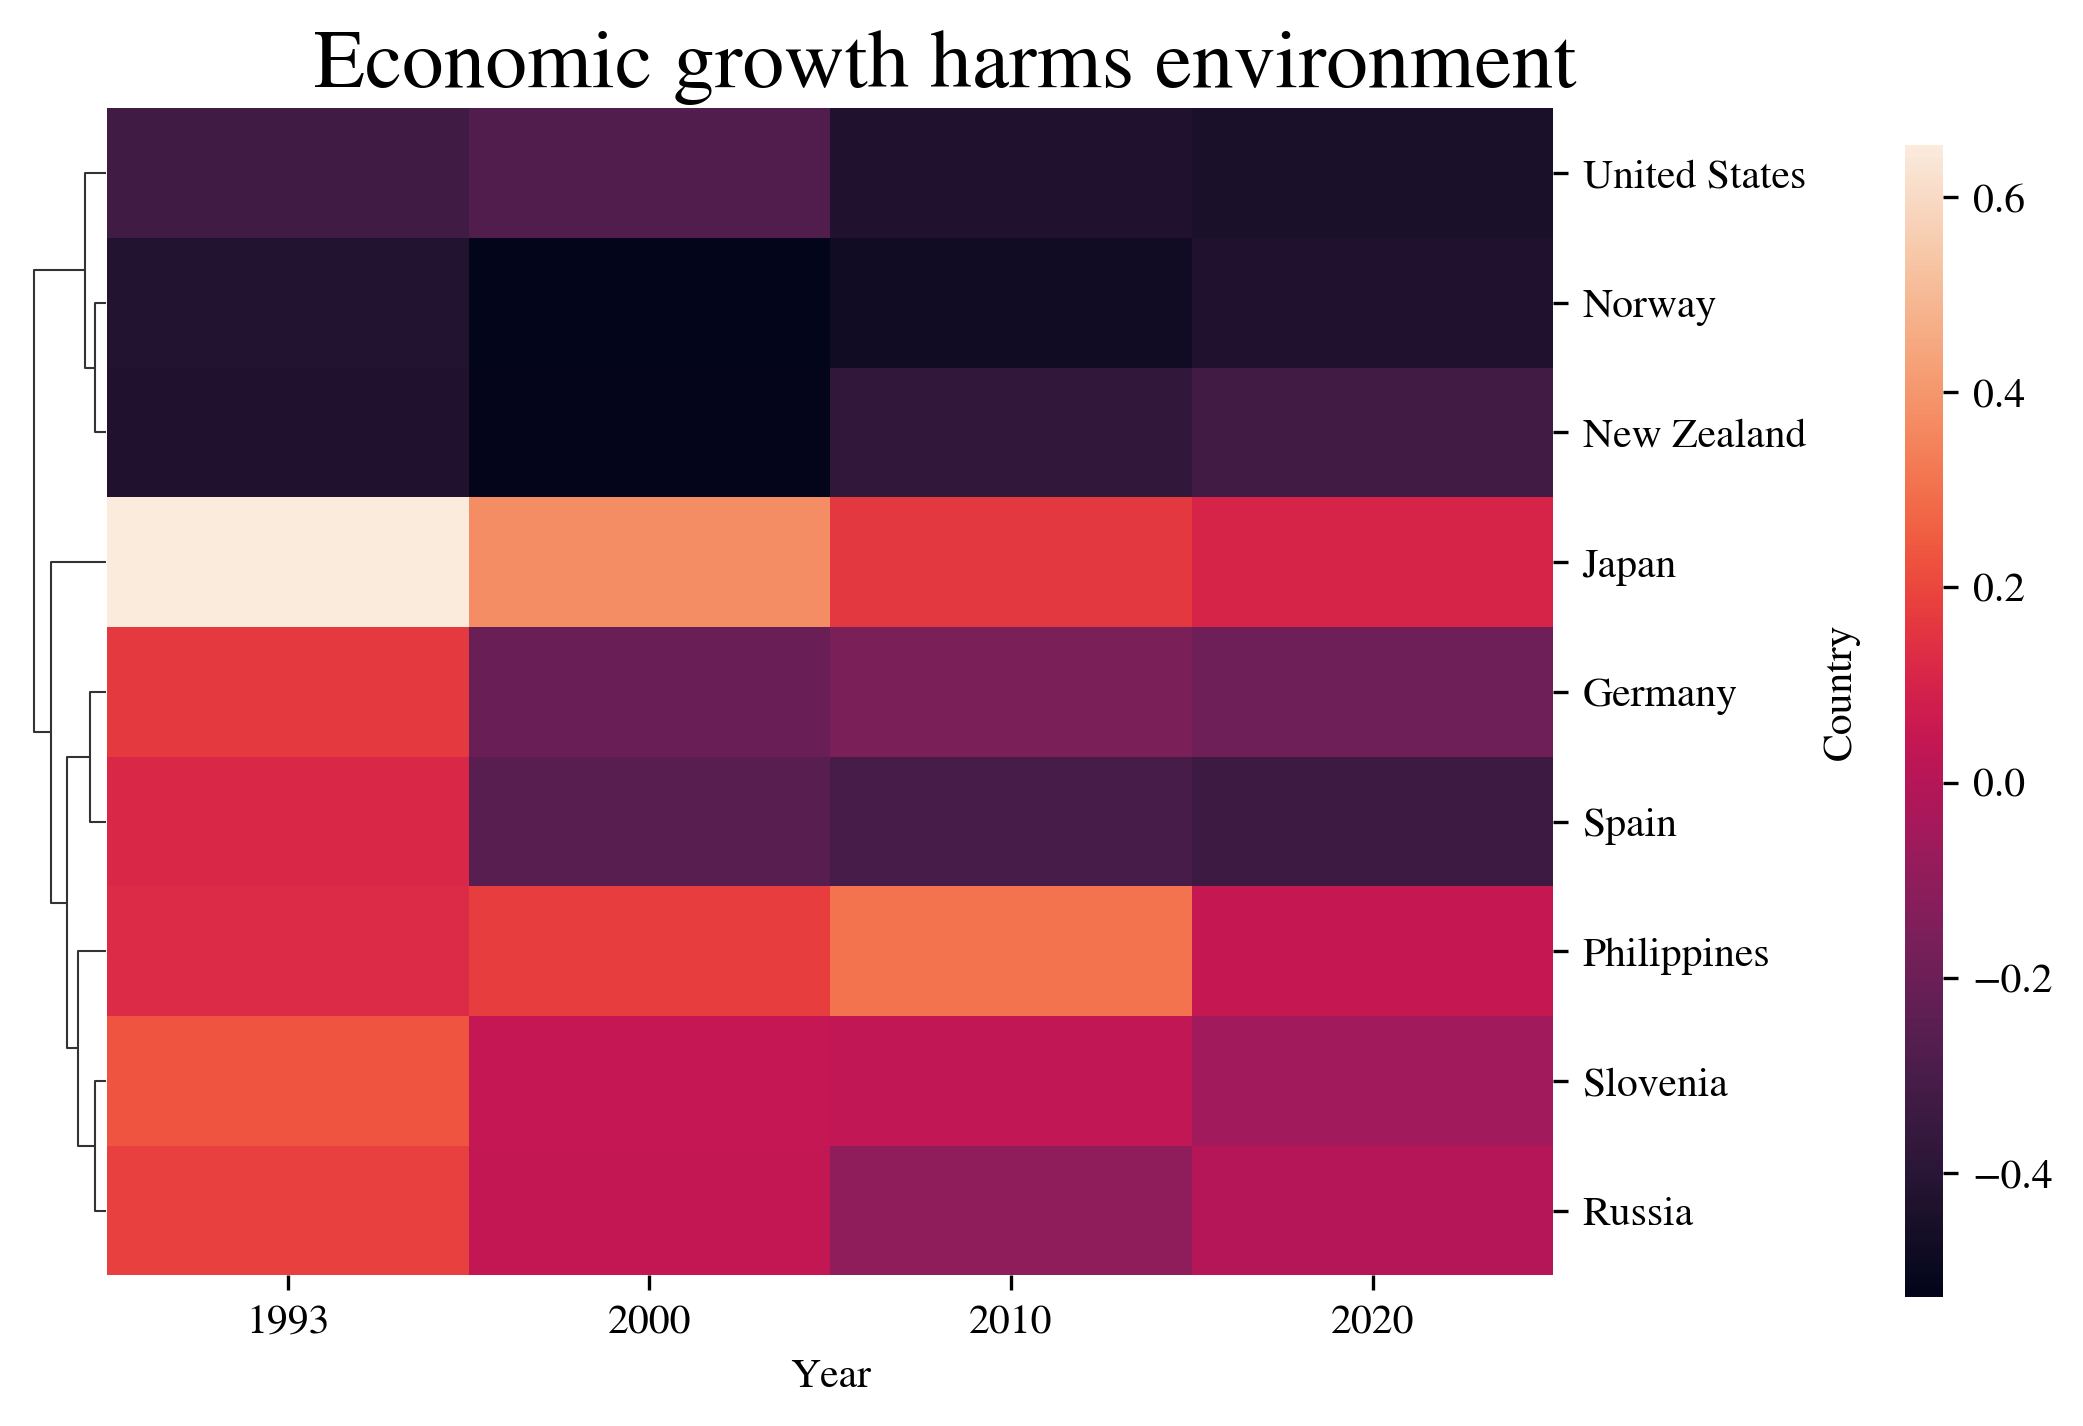

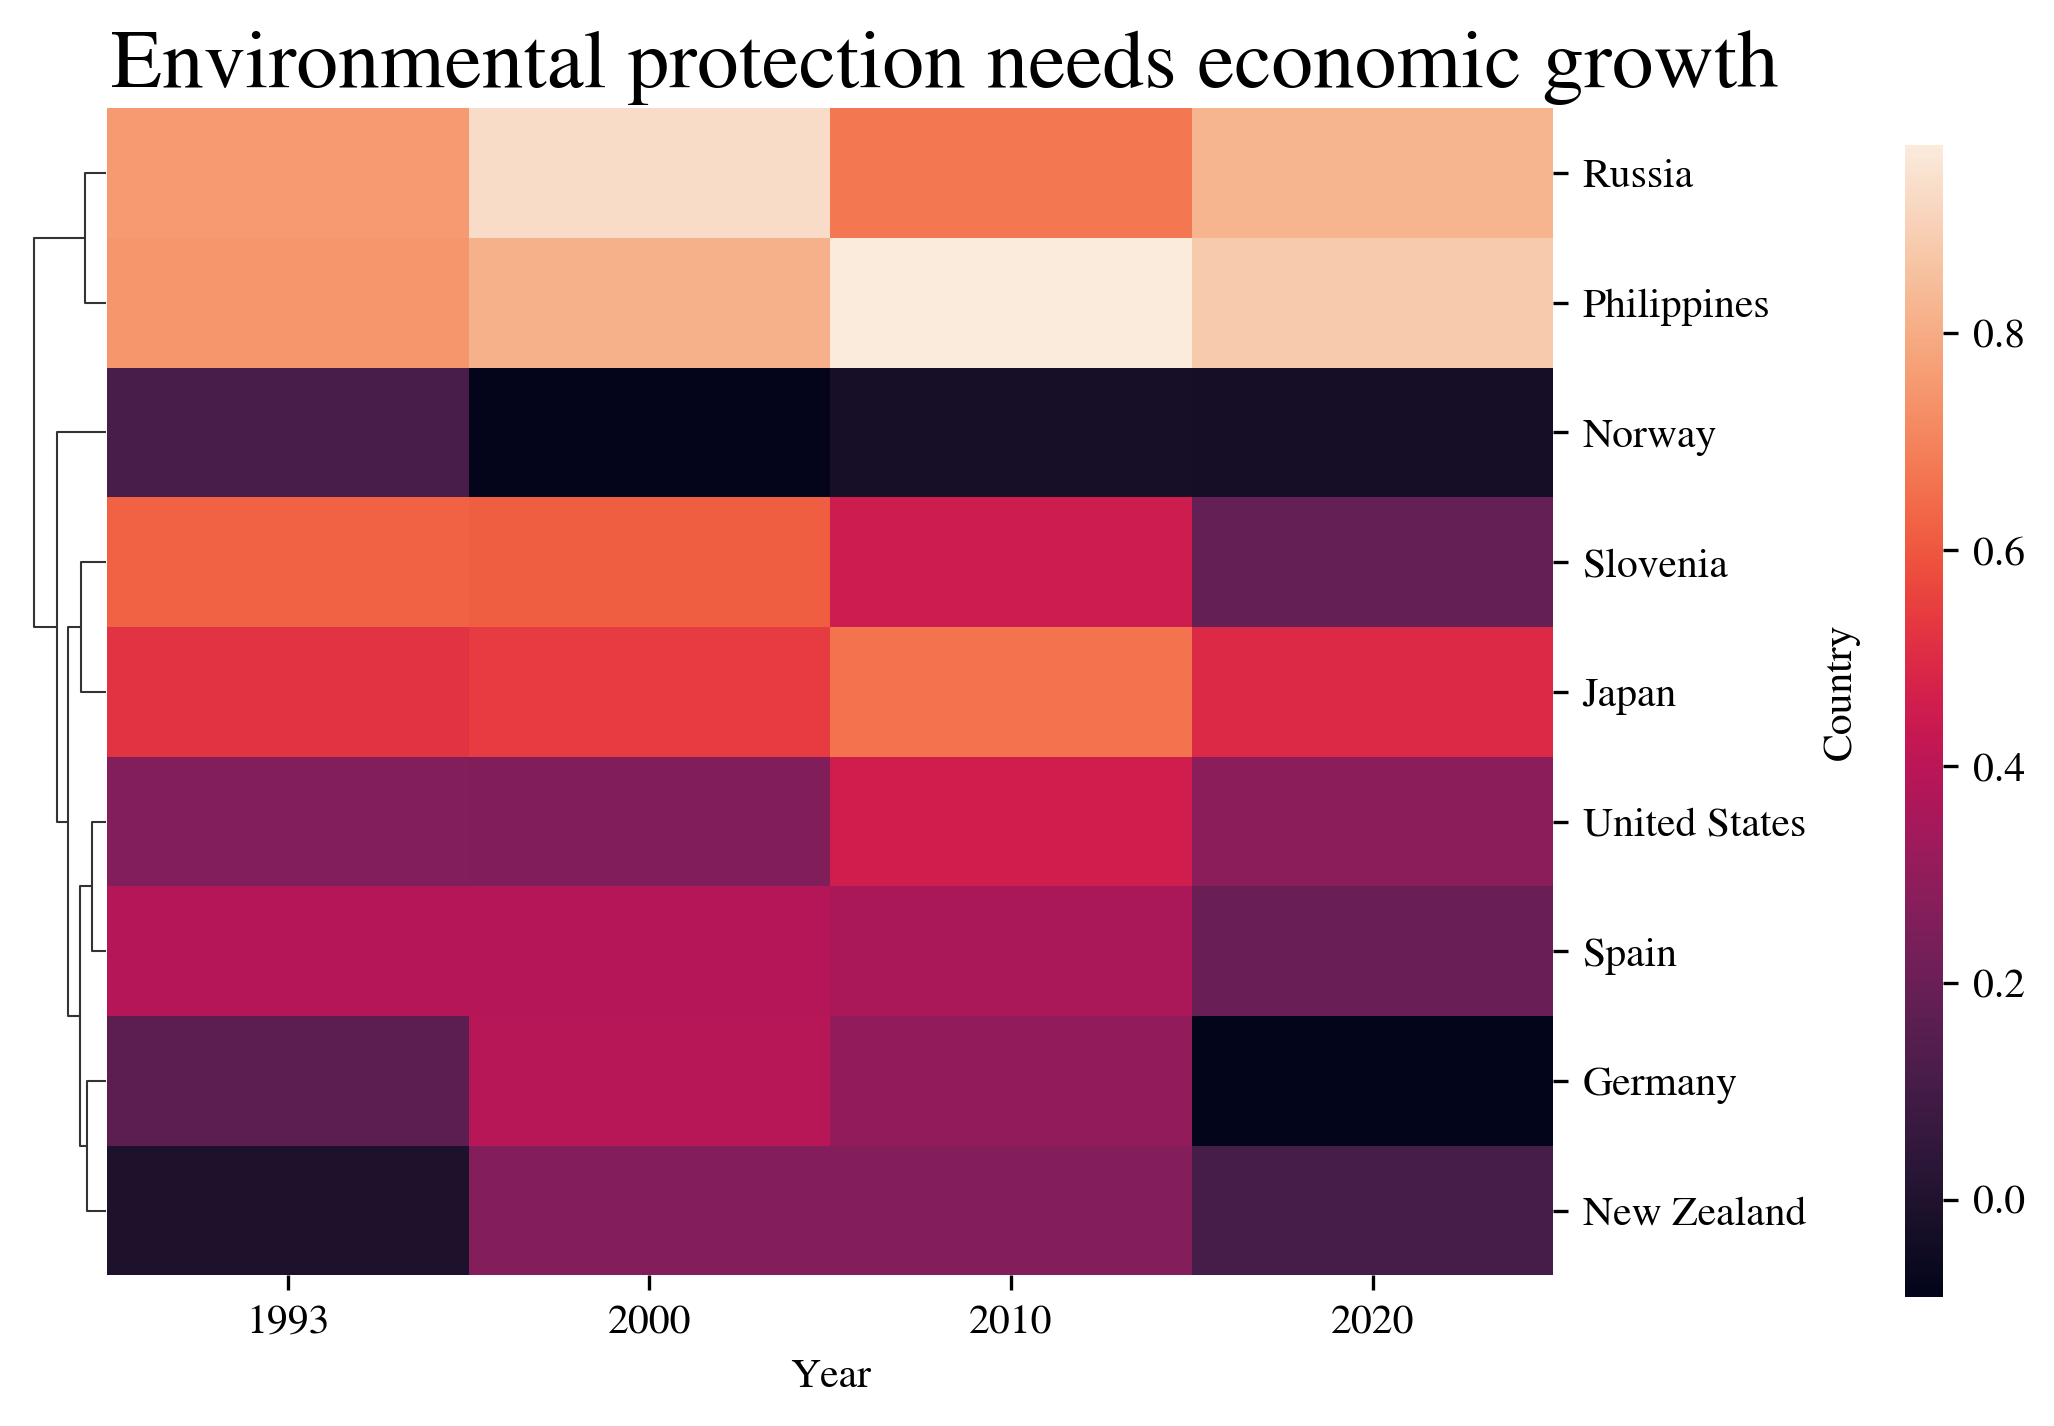

In [9]:
for q in ["Economic growth harms environment", "Environmental protection needs economic growth"]:
    data = data_issp.query("Country != 'Taiwan'").loc[:,[q, "Weight"]].copy()
    data = data.map(conv_answers).astype(float)
    data = data[[q]].mul(data["Weight"], axis="index").groupby(["Year", "Country"]).sum().div(data["Weight"].groupby(["Year", "Country"]).sum(), axis="index")
    data = data[q].reset_index().pivot(index="Country", columns="Year", values=q)
    
    common_countries = [c for c in data_issp.index.get_level_values("Country").unique() if np.all([(y,c) in [(i[0],i[1]) for i in data_issp.index] for y in [1993,2000,2010,2020]])]
    
    sns.clustermap(data.loc[common_countries, :], col_cluster=False, dendrogram_ratio=0.05, figsize=(6.4,4.8), cbar_pos=(1,0.1,.02,.8))
    plt.gcf().suptitle(q, fontsize=20)
    
    del(data)

___